In [ ]:
pip install pymannkendall

In [ ]:
# =========================================
# Librerías estándar
# =========================================
import calendar
from itertools import product

# =========================================
# Ciencia de datos y visualización
# =========================================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# =========================================
# Estadística y tests
# =========================================
from scipy.stats import (
    shapiro, skew, kurtosis,
    pearsonr, spearmanr, kendalltau, kruskal
)

# =========================================
# Time series: tests, modelos y utilidades
# =========================================
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# (import duplicado, mantenido a pedido)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prueba de tendencia Mann-Kendall
import pymannkendall as mk

# =========================================
# Scikit-learn: preprocesamiento, modelos, CV y métricas
# =========================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.feature_selection import RFECV

from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# =========================================
# Gradient Boosting
# =========================================
from lightgbm import LGBMRegressor


In [ ]:
df = pd.read_excel("MEM Final.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             91 non-null     datetime64[ns]
 1   BarrilPetroleo    91 non-null     float64       
 2   TempMedia         91 non-null     float64       
 3   DemandaLocal+Exp  91 non-null     float64       
 4   OfertaTotal       91 non-null     float64       
 5   GasNatural        91 non-null     float64       
 6   FuelOil           91 non-null     float64       
 7   GasOil            91 non-null     float64       
 8   CarbonMineral     91 non-null     float64       
 9   CombustTotal      91 non-null     float64       
 10  CostoMonomico     91 non-null     float64       
 11  CombustAlt        91 non-null     float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 8.7 KB


In [ ]:
df.head()

,Fecha,BarrilPetroleo,TempMedia,DemandaLocal+Exp,OfertaTotal,GasNatural,FuelOil,GasOil,CarbonMineral,CombustTotal,CostoMonomico,CombustAlt
0,2018-01-01,69.08,26.135484,12350.276708,12748.799973,5.518258,342.658506,338.486903,129.086942,410.384262,76.04,36.878944
1,2018-02-01,65.32,25.180357,11404.202907,11769.991247,5.507254,331.575409,330.704144,137.238698,388.358311,76.38,46.869249
2,2018-03-01,66.02,22.382258,11250.044147,11629.804813,5.492190,341.199569,330.239527,145.008787,370.160565,74.73,26.488278
3,2018-04-01,72.11,22.081667,10503.581602,10853.365862,5.397111,352.772592,351.082578,146.013489,346.480618,76.65,14.397546
4,2018-05-01,76.98,16.606452,10665.461535,11018.902262,5.529249,329.318893,352.384631,149.473794,331.619440,78.15,12.779675


# Tratamiento de NA

In [ ]:
# Ver cantidad de NAs por columna
na_counts = df.isna().sum()

# Total de filas
n_rows = len(df)

# Tabla con % de NAs
na_summary = pd.DataFrame({
    'NAs': na_counts,
    'Porcentaje': (na_counts / n_rows * 100).round(2)
}).sort_values(by='NAs', ascending=False)

print("🔎 Resumen de valores faltantes (NAs) en variables originales:")
display(na_summary)

🔎 Resumen de valores faltantes (NAs) en variables originales:


,NAs,Porcentaje
Fecha,0,0.0
BarrilPetroleo,0,0.0
TempMedia,0,0.0
DemandaLocal+Exp,0,0.0
OfertaTotal,0,0.0
GasNatural,0,0.0
FuelOil,0,0.0
GasOil,0,0.0
CarbonMineral,0,0.0
CombustTotal,0,0.0


# Visualizacion y tratamiento de outliers

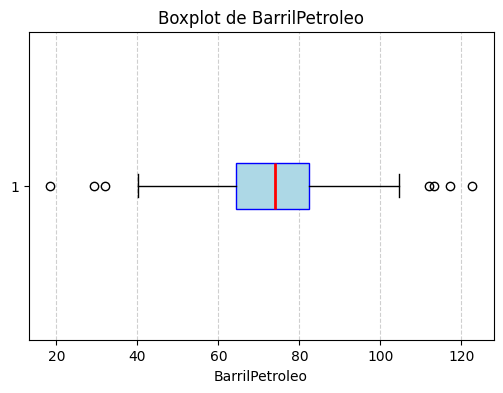

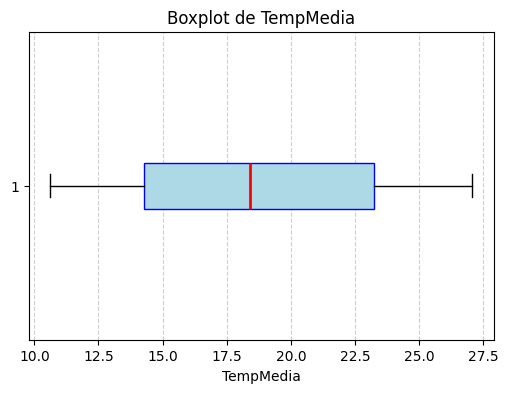

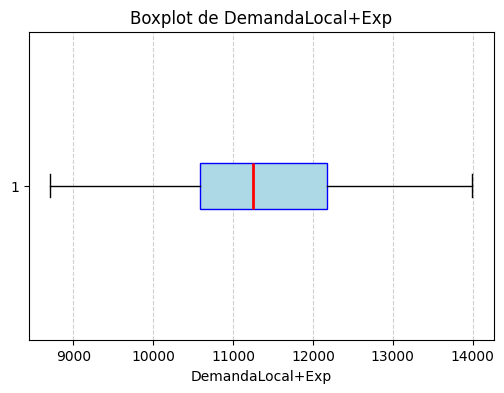

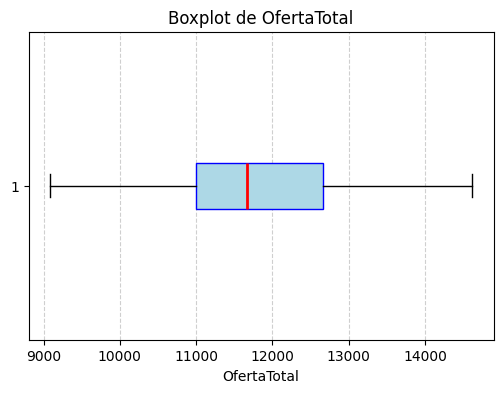

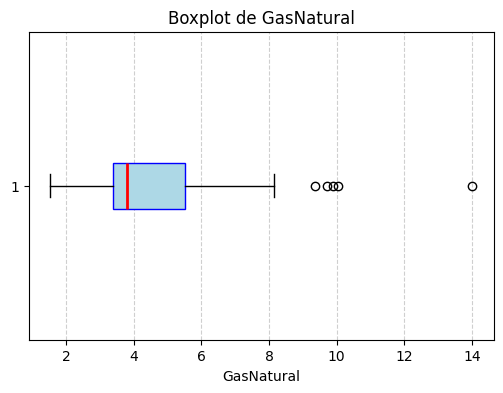

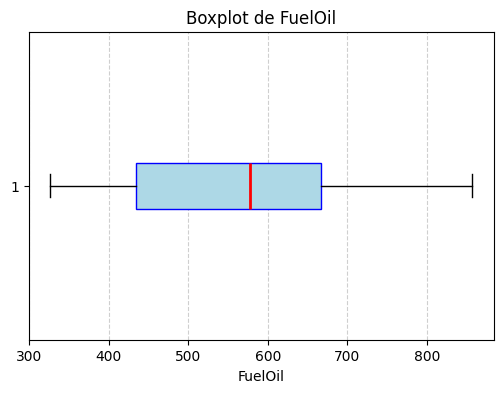

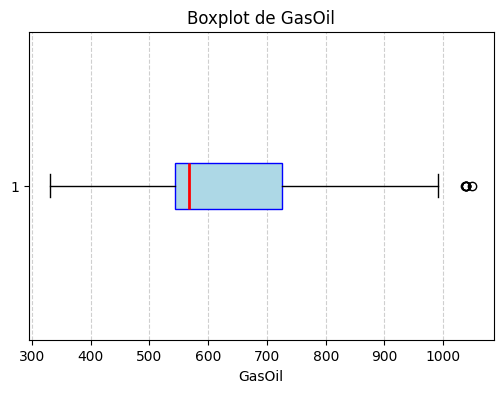

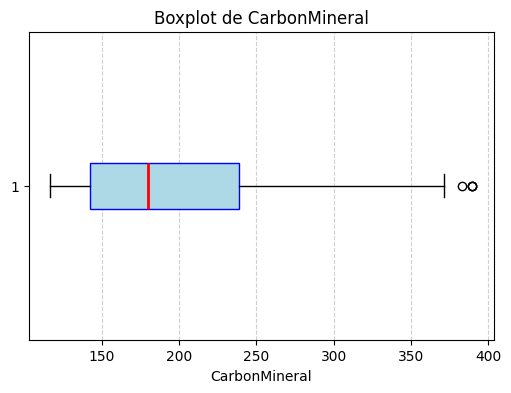

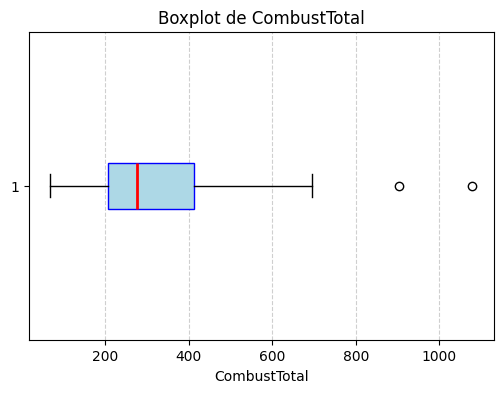

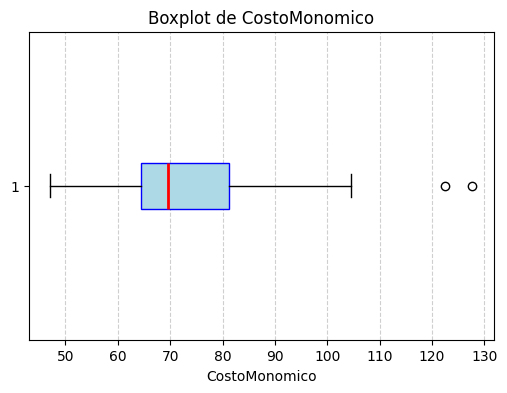

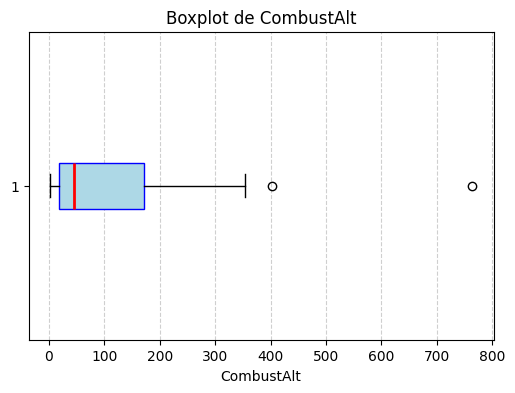

In [ ]:
# Seleccionamos solo columnas numéricas
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()

# Generar un boxplot por cada variable numérica
for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col].dropna(), vert=False, patch_artist=True,
                boxprops=dict(facecolor="lightblue", color="blue"),
                medianprops=dict(color="red", linewidth=2))
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()


<Axes: title={'center': 'Mapa de calor'}>

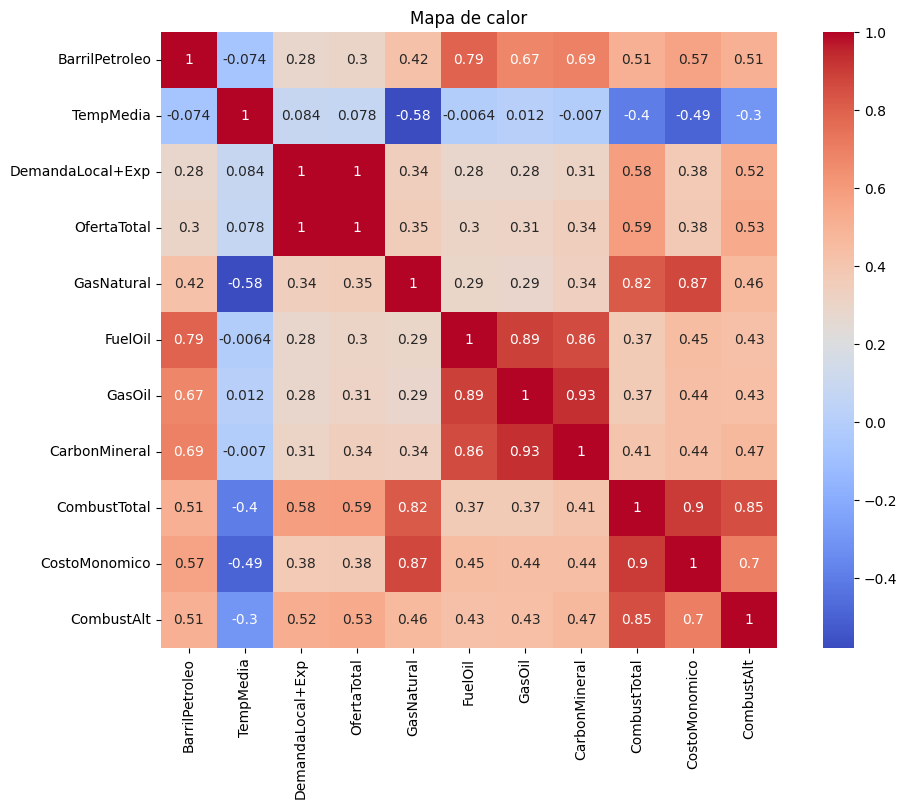

In [ ]:
# Computar matriz de correlación sin la columna 'Fecha'
corr_matrix = df.drop(columns=['Fecha']).corr()
# Generate heatmap
plt.figure(figsize=(12, 8))
plt.title("Mapa de calor")
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

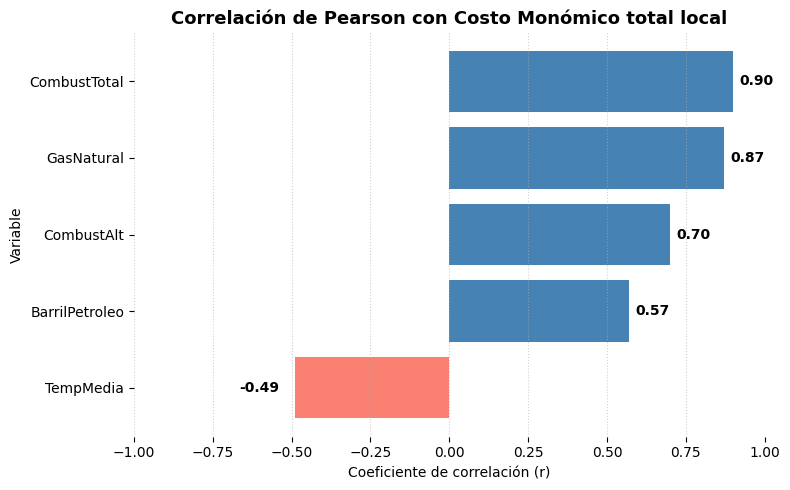

In [ ]:
# --- Ejemplo: correlaciones (podés reemplazar con tus datos reales) ---
corr_data = {
    'Variable': [
        'CombustTotal',
        'GasNatural',
        'CombustAlt',
        'BarrilPetroleo',
        'TempMedia'
    ],
    'r': [0.90, 0.87, 0.70, 0.57, -0.49]
}

df_corr = pd.DataFrame(corr_data)

# Ordenar por valor de correlación
df_corr = df_corr.sort_values('r', ascending=True)

# Colores: azul para positivos, rojo para negativos
colors = df_corr['r'].apply(lambda x: 'salmon' if x < 0 else 'steelblue')

# --- Gráfico ---
plt.figure(figsize=(8,5))
bars = plt.barh(df_corr['Variable'], df_corr['r'], color=colors)

# Etiquetas numéricas al final de cada barra
for bar, value in zip(bars, df_corr['r']):
    xpos = value - 0.05 if value < 0 else value + 0.02
    align = 'right' if value < 0 else 'left'
    plt.text(xpos, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}", va='center', ha=align, fontsize=10, fontweight='bold')

# Estilo general
plt.title("Correlación de Pearson con Costo Monómico total local", fontsize=13, weight='bold')
plt.xlabel("Coeficiente de correlación (r)")
plt.ylabel("Variable")
plt.xlim(-1, 1)
plt.grid(axis='x', linestyle=':', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### Explicacion de Outliers por Estacionalidad o relacion entre variables

<Figure size 1000x500 with 0 Axes>

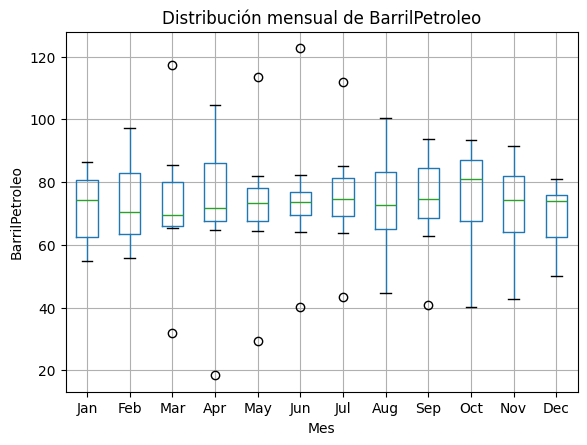

<Figure size 1000x500 with 0 Axes>

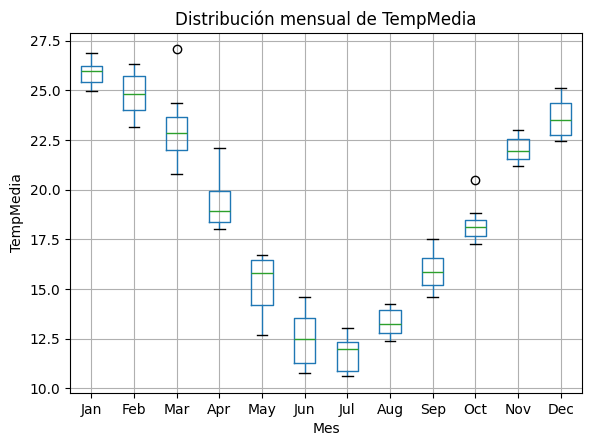

<Figure size 1000x500 with 0 Axes>

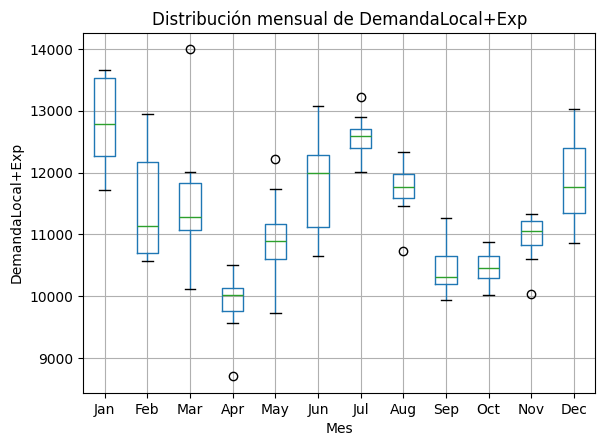

<Figure size 1000x500 with 0 Axes>

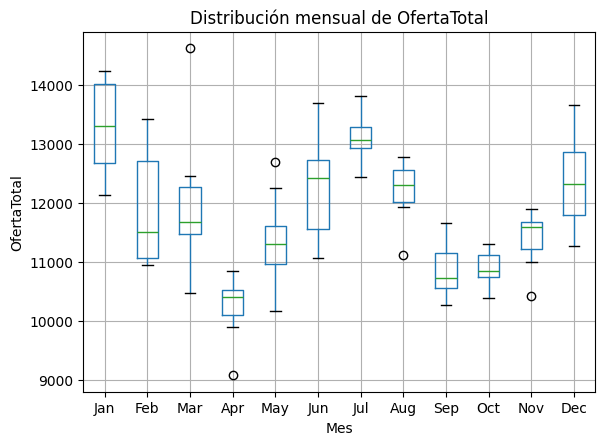

<Figure size 1000x500 with 0 Axes>

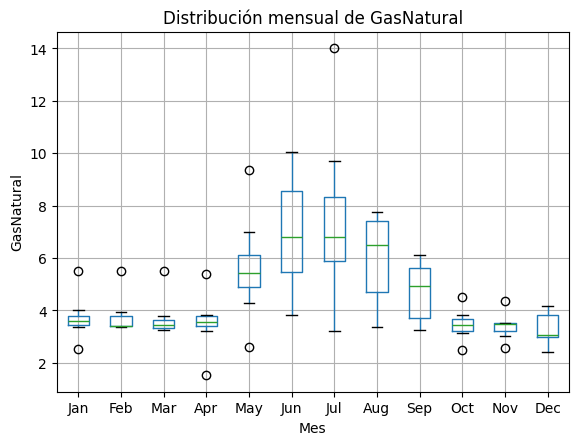

<Figure size 1000x500 with 0 Axes>

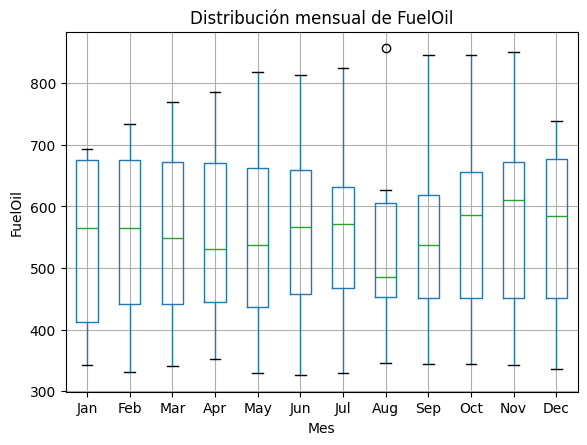

<Figure size 1000x500 with 0 Axes>

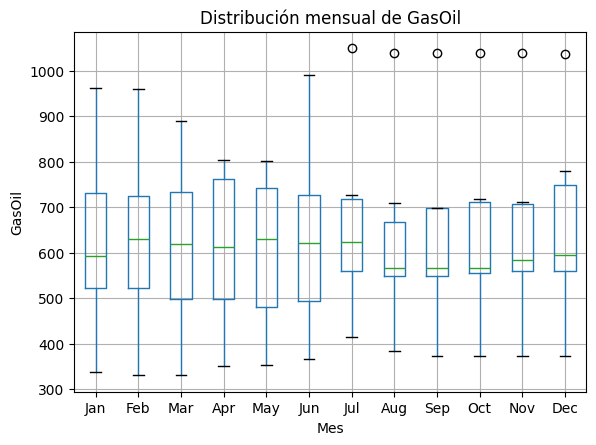

<Figure size 1000x500 with 0 Axes>

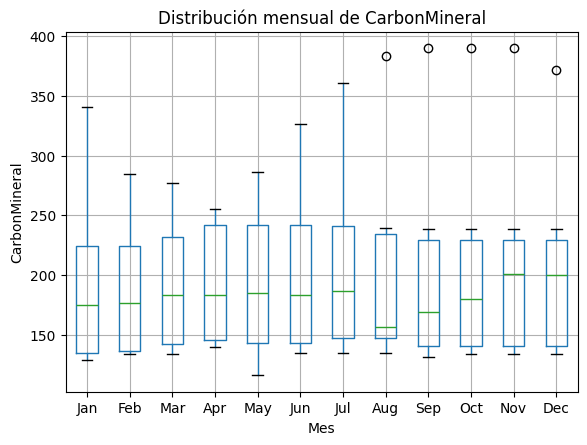

<Figure size 1000x500 with 0 Axes>

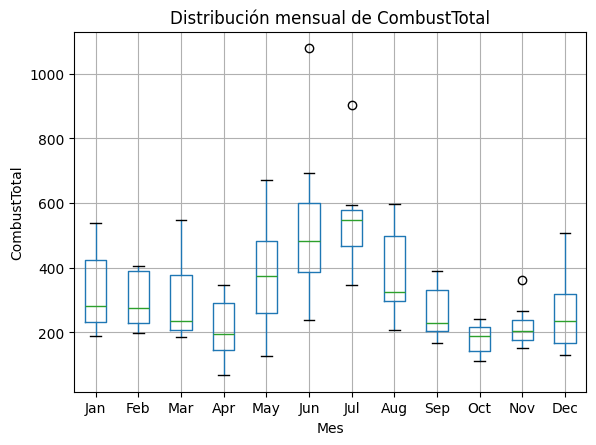

<Figure size 1000x500 with 0 Axes>

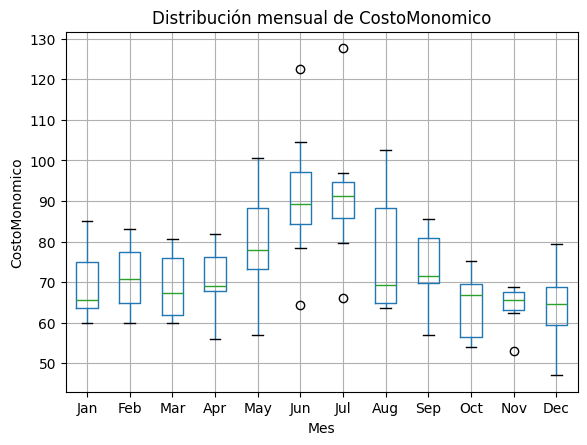

<Figure size 1000x500 with 0 Axes>

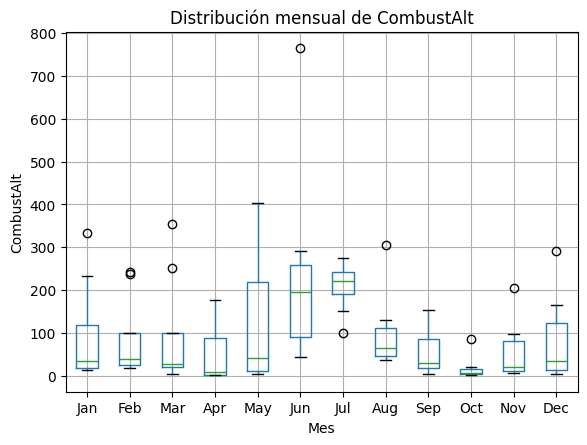

In [ ]:
df['Mes'] = df['Fecha'].dt.month

for col in num_cols:
    plt.figure(figsize=(10,5))
    df.boxplot(column=col, by='Mes')
    plt.title(f"Distribución mensual de {col}")
    plt.suptitle("")
    plt.xlabel("Mes")
    plt.ylabel(col)
    plt.xticks(range(1,13), [calendar.month_abbr[m] for m in range(1,13)])
    plt.show()


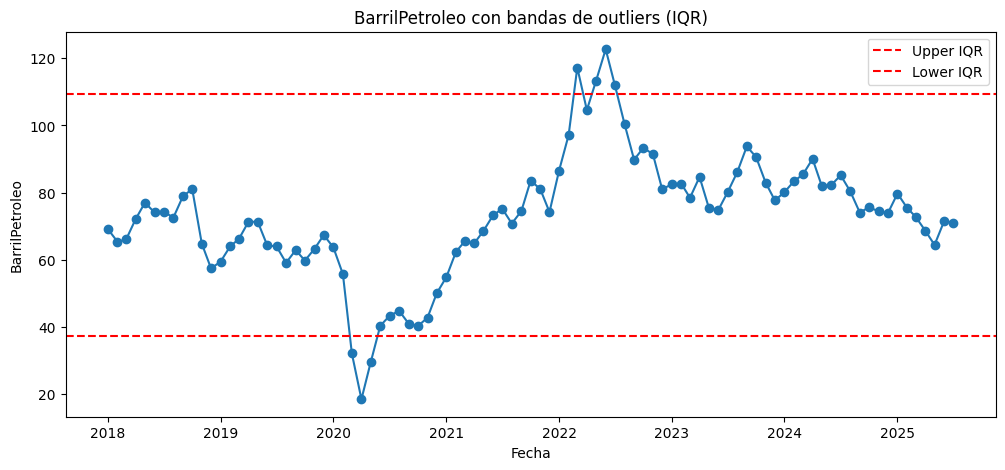

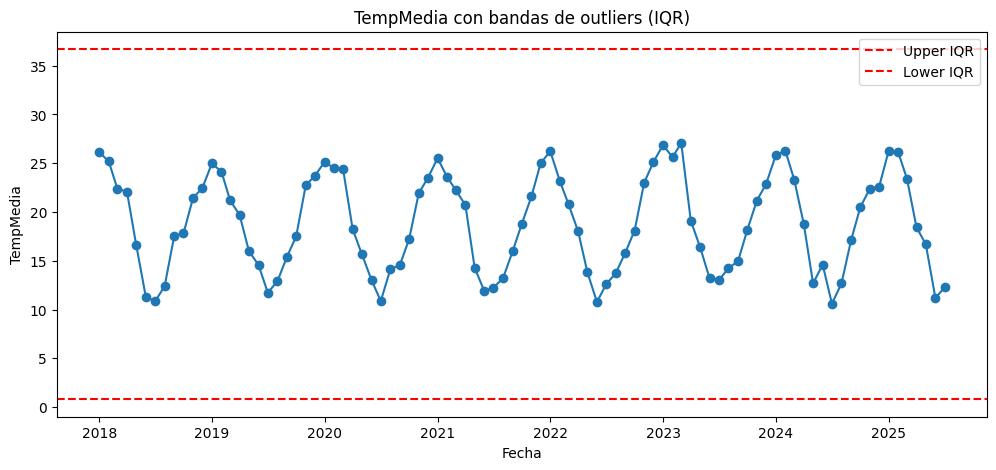

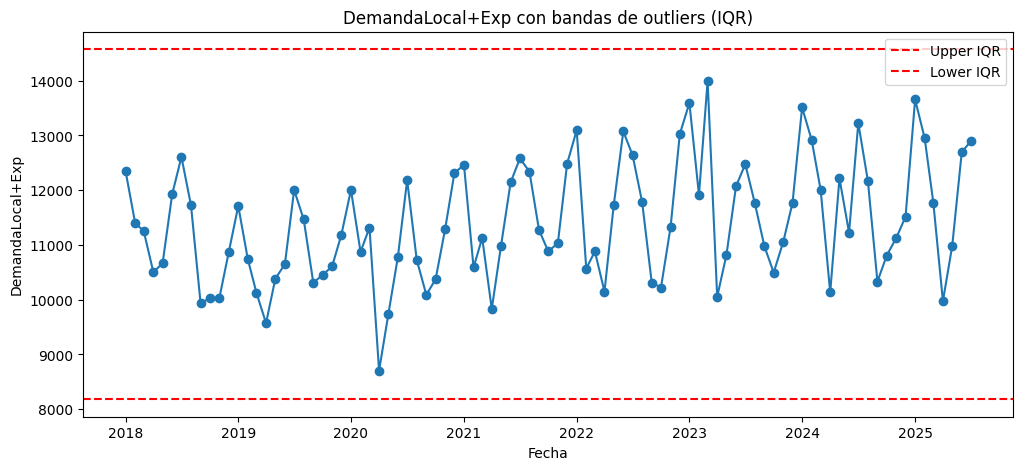

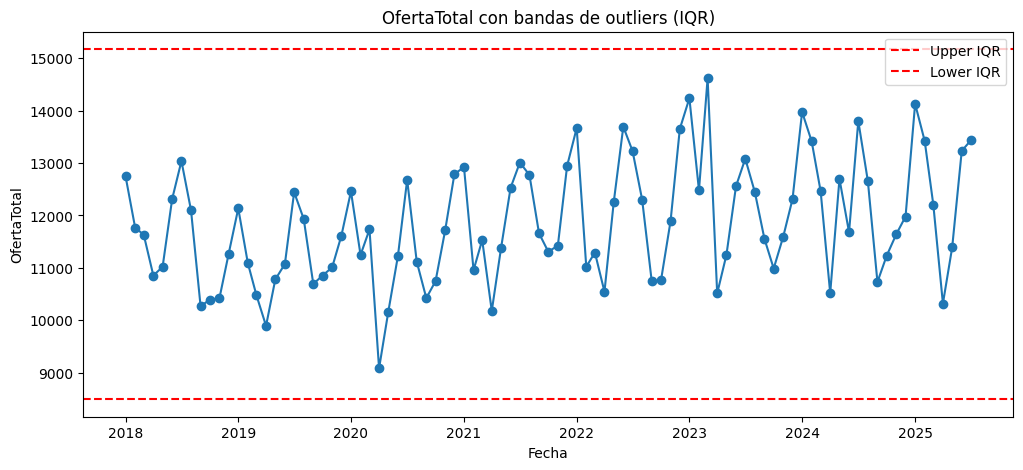

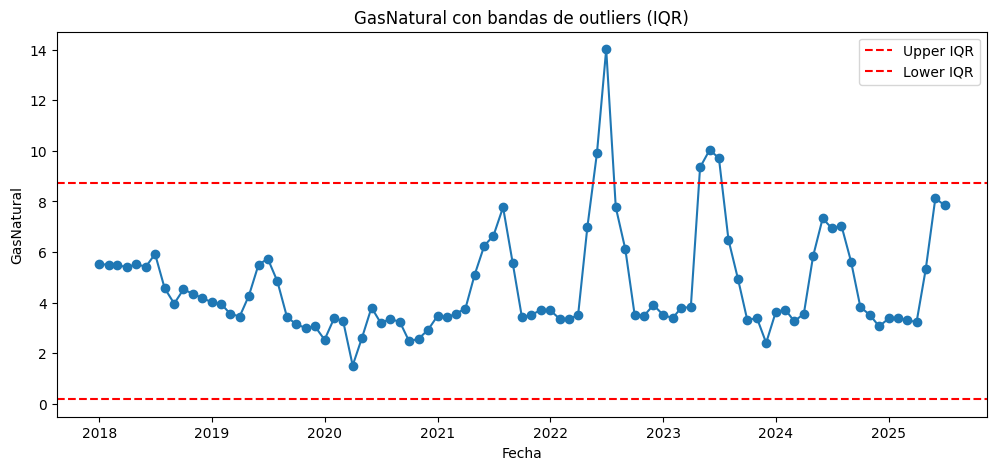

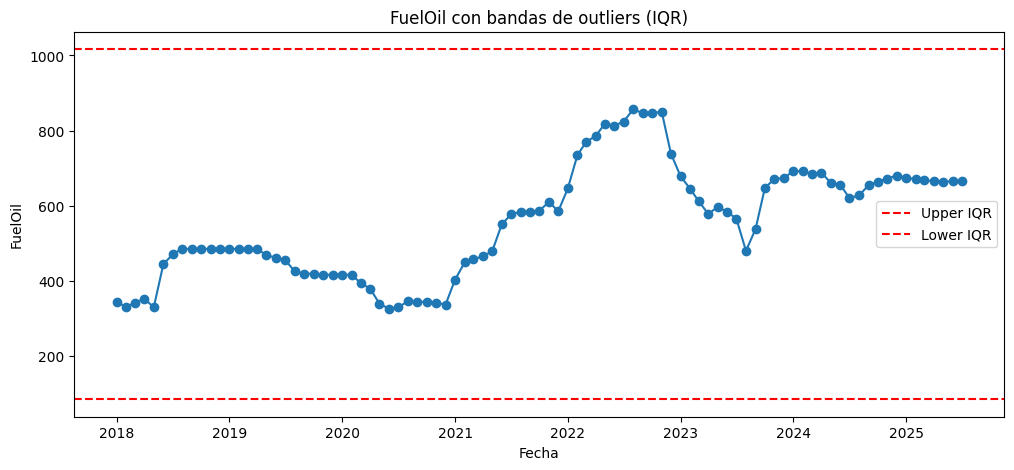

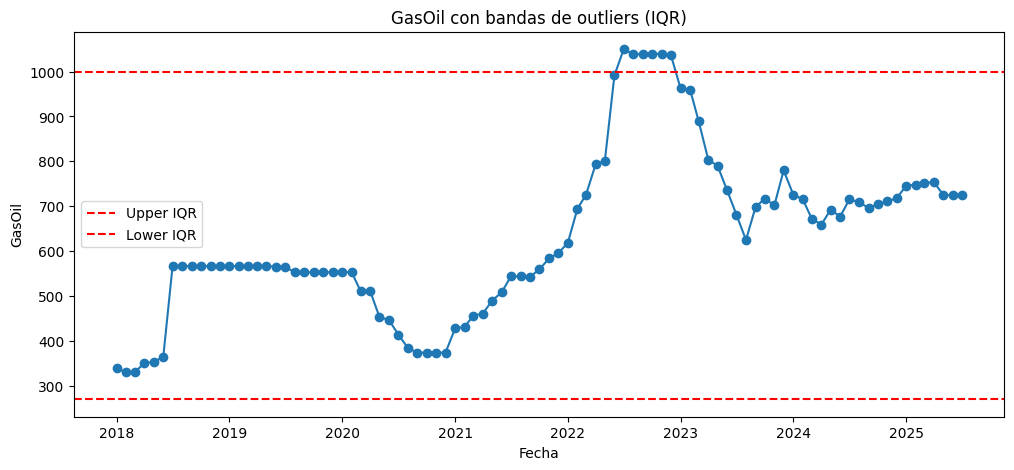

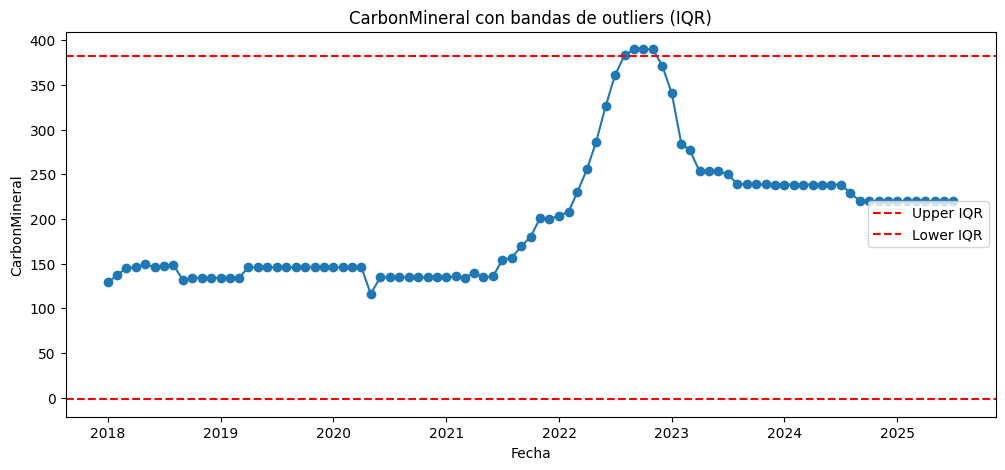

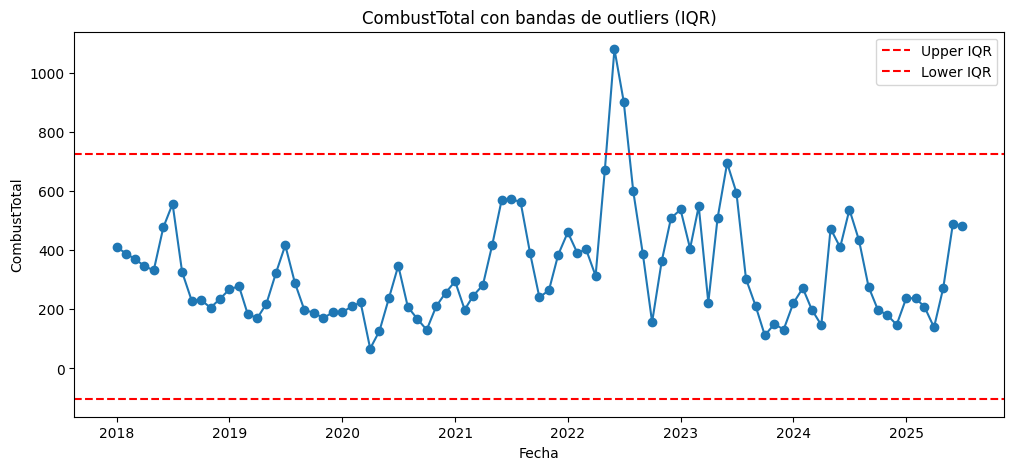

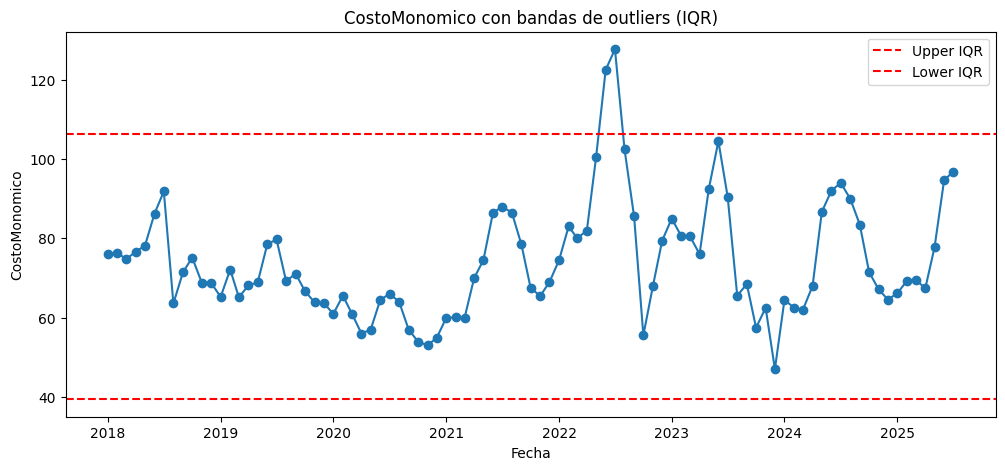

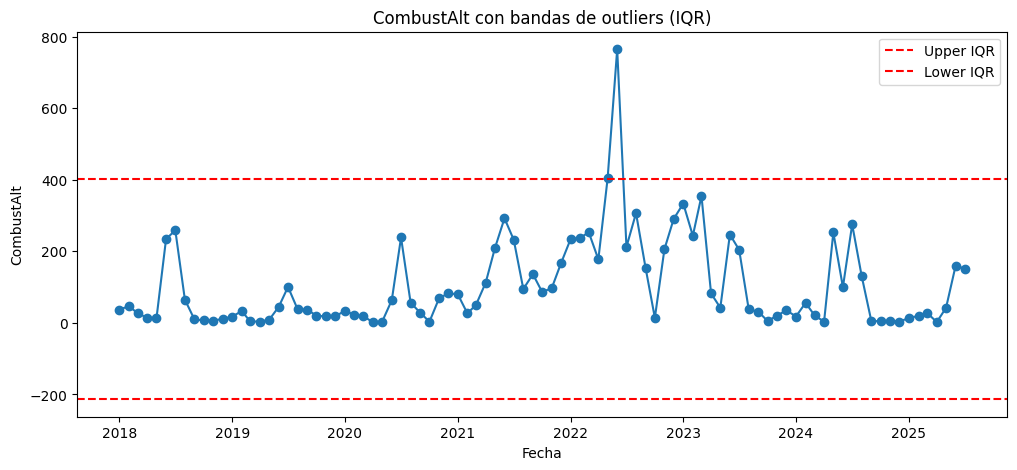

In [ ]:
for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    plt.figure(figsize=(12,5))
    plt.plot(df['Fecha'], df[col], marker='o')
    plt.axhline(upper, color='red', linestyle='--', label='Upper IQR')
    plt.axhline(lower, color='red', linestyle='--', label='Lower IQR')
    plt.title(f"{col} con bandas de outliers (IQR)")
    plt.xlabel("Fecha")
    plt.ylabel(col)
    plt.legend()
    plt.show()

# Tendencia (d)

In [ ]:
serie = df.set_index('Fecha')['CostoMonomico'].sort_index()
serie = serie.asfreq('MS')  # inicio de mes; ajustá si usás 'M'
serie = serie.dropna()

In [ ]:
# (a) Test clásico (sin estacionalidad)
mk_res = mk.original_test(serie.values)
print(mk_res)  # mk_res.trend, mk_res.p

# (b) Test estacional (si tenés estacionalidad mensual)
mk_seas = mk.seasonal_test(serie.values, period=12)
print(mk_seas)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.15087474822966596), z=np.float64(1.4364485441889268), Tau=np.float64(0.10256410256410256), s=np.float64(420.0), var_s=np.float64(85084.0), slope=np.float64(0.06757575757575769), intercept=np.float64(66.54755080074614))
Seasonal_Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.19196087536989093), z=np.float64(1.3048002459706716), Tau=np.float64(0.11627906976744186), s=np.float64(35.0), var_s=679.0, slope=np.float64(0.7799999999999976), intercept=np.float64(66.66345989165524))


In [ ]:
# Serie mensual, indexada y sin NaN:
serie = df.set_index('Fecha')['CostoMonomico'].sort_index().asfreq('MS').dropna()

# ADF con constante y tendencia (H0: raíz unitaria = no estacionaria)
adf_stat, adf_p, *_ = adfuller(serie, regression='ct', autolag='AIC')
print(f"ADF (ct): stat={adf_stat:.3f}, p={adf_p:.4f}")

# KPSS con tendencia (H0: estacionaria alrededor de una tendencia)
kpss_stat, kpss_p, *_ = kpss(serie, regression='ct', nlags='auto')
print(f"KPSS (ct): stat={kpss_stat:.3f}, p={kpss_p:.4f}")

ADF (ct): stat=-1.958, p=0.6242
KPSS (ct): stat=0.092, p=0.1000


/tmp/ipython-input-3673326051.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(serie, regression='ct', nlags='auto')


Evaluación de tendencia en la serie
Para contrastar la presencia de tendencia aplicamos: (i) Mann–Kendall clásico y Mann–Kendall estacional (periodicidad 12), (ii) Dickey–Fuller Aumentado (ADF) con constante y tendencia, y (iii) KPSS con constante y tendencia. Los resultados fueron: MK clásico p=0.1509 y MK estacional p=0.1920 (ambos “no trend”); ADF(ct) p=0.6242 (no se rechaza raíz unitaria) y KPSS(ct) p>0.10 (no se rechaza estacionariedad alrededor de una tendencia determinística). En conjunto, no hay evidencia estadísticamente significativa de una tendencia determinística en la serie, y la señal ADF vs. KPSS es mixta respecto de raíz unitaria. Por criterio de parsimonia y dado el tamaño muestral, no aplicamos diferenciación de orden 1 (d=0) en esta etapa; modelaremos con los rezagos y la estacionalidad explícita, y verificaremos la estacionariedad en los residuos (ACF/PACF y tests) tras el ajuste. Si los diagnósticos indicaran no-estacionariedad remanente, reconsideraremos la diferenciación.

# Estacionalidad

In [ ]:
y = df.set_index('Fecha')['CostoMonomico'].sort_index().asfreq('MS').dropna()

acf_vals = acf(y, nlags=24, fft=True)
rho12 = acf_vals[12]
z12 = rho12 * np.sqrt(len(y))
print(f"ACF(12) = {rho12:.3f} | z ≈ {z12:.2f} (|z|>1.96 ≈ significativo, aprox.)")

# Ljung–Box en lags estacionales
lb = acorr_ljungbox(y, lags=[12,24], return_df=True)
print(lb)

ACF(12) = 0.455 | z ≈ 4.34 (|z|>1.96 ≈ significativo, aprox.)
       lb_stat     lb_pvalue
12  126.373747  3.291744e-21
24  210.026559  1.184050e-31


Nuestros numeros dicen:

ACF(12) = 0.455 con z ≈ 4.34 → el pico en el lag 12 es claramente significativo.

Ljung–Box(12) y (24) con p-values ~ 10⁻²¹ y 10⁻³¹ → rechazo ruido blanco con mucha fuerza; hay dependencia serial, y dado el pico en 12, es estacionalidad anual.

Conclusión

Nuestra serie tiene estacionalidad fuerte con periodo 12 meses.

# ACF Y PACF y determinacion de modelos ARIMA y SARIMA

<Figure size 1200x500 with 0 Axes>

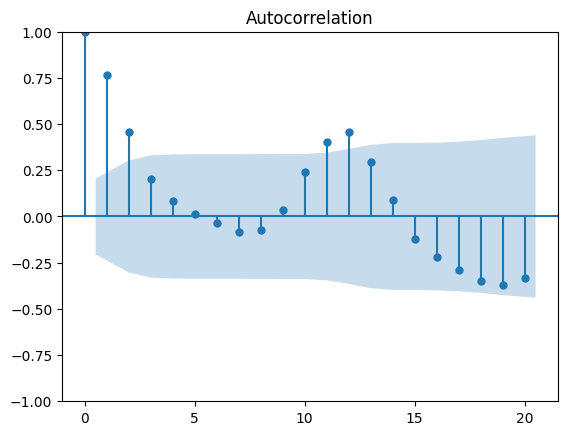

<Figure size 1200x500 with 0 Axes>

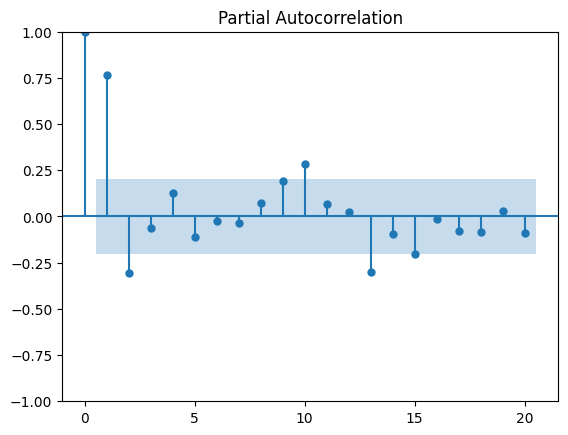

In [ ]:
plt.figure(figsize=(12,5))
plot_acf(df['CostoMonomico'], lags=20)  # probar hasta 20 rezagos
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['CostoMonomico'], lags=20)
plt.show()

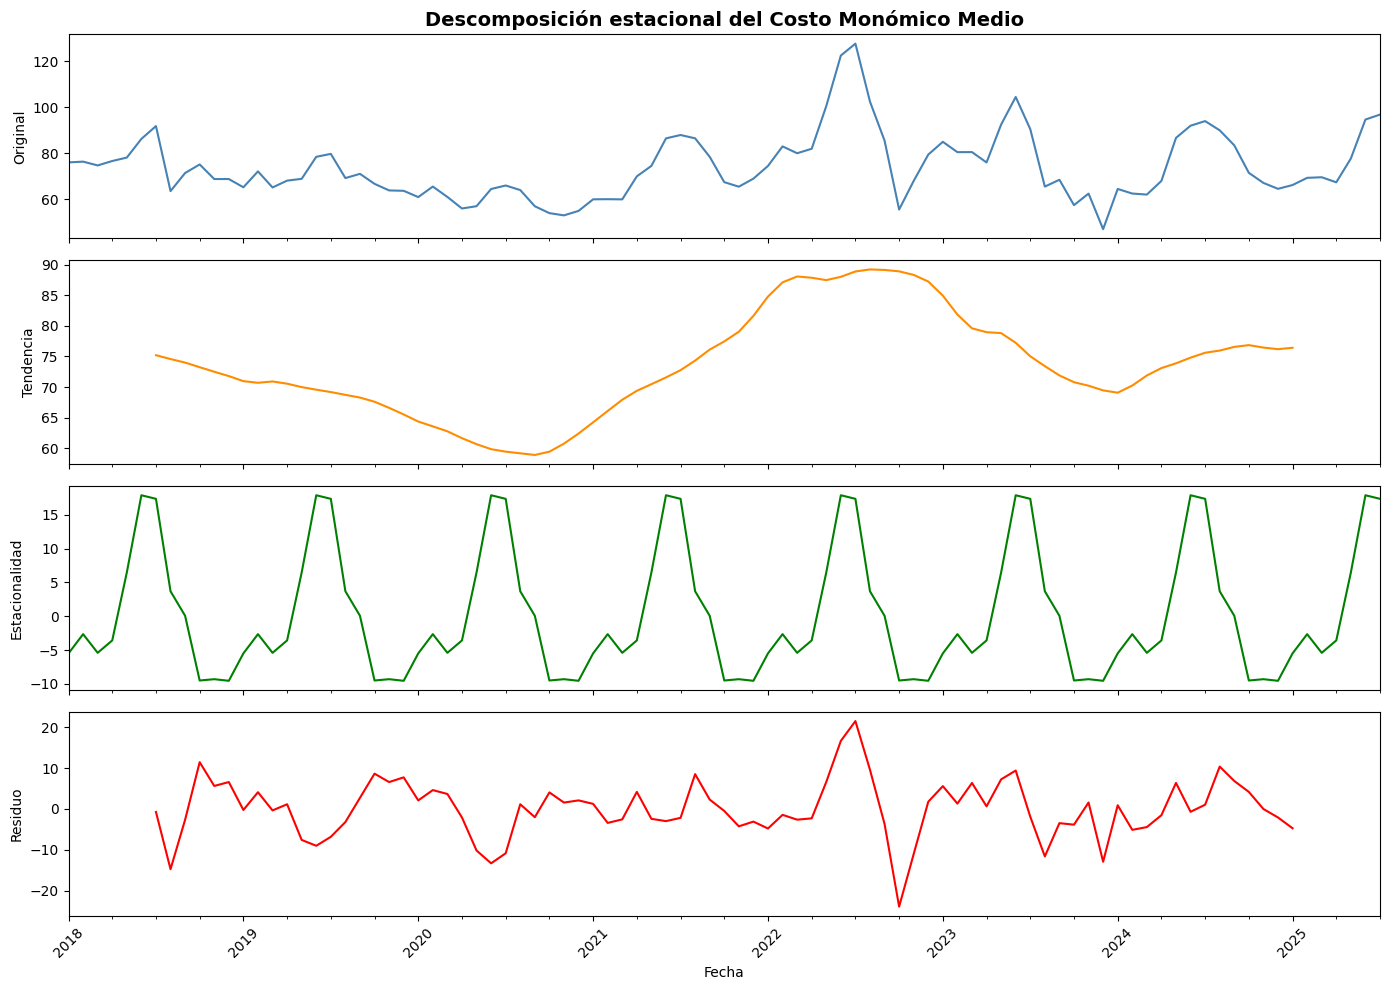

In [ ]:
# Serie con índice de fechas
serie = df.set_index('Fecha')['CostoMonomico']

# Descomposición
result = seasonal_decompose(serie, model='additive', period=12)

# Crear figura
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Configuración del eje x en formato meses
date_fmt = mdates.DateFormatter("%b-%Y")  # Ej: Jan-2018
for ax in axes:
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # cada 3 meses
    ax.grid(True, linestyle="--", alpha=0.5)

# Plot de cada componente
result.observed.plot(ax=axes[0], color="steelblue")
axes[0].set_ylabel("Original")
axes[0].set_title("Descomposición estacional del Costo Monómico Medio", fontsize=14, fontweight="bold")

result.trend.plot(ax=axes[1], color="darkorange")
axes[1].set_ylabel("Tendencia")

result.seasonal.plot(ax=axes[2], color="green")
axes[2].set_ylabel("Estacionalidad")

result.resid.plot(ax=axes[3], color="red")
axes[3].set_ylabel("Residuo")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 2000x550 with 0 Axes>

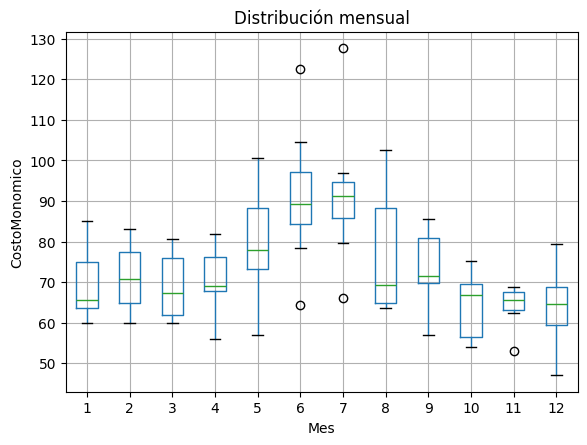

In [ ]:
df['Mes'] = df['Fecha'].dt.month
plt.figure(figsize=(20, 5.5))
df.boxplot(column='CostoMonomico', by='Mes')
plt.title("Distribución mensual")
plt.suptitle("")
plt.xlabel("Mes")
plt.ylabel("CostoMonomico")
plt.show()


In [ ]:
## Diferencia estadisticamente significativa entre mediana de meses

grupos = [df.loc[df['Mes']==m, 'CostoMonomico'] for m in range(1,13)]
stat, p = kruskal(*grupos)
print("Kruskal-Wallis H-test → estadístico:", stat, "p-valor:", p)

Kruskal-Wallis H-test → estadístico: 33.140367389679604 p-valor: 0.0004992995920010158


## ARIMA

Train: 84 | Test: 7
Train: 2018-01-01 -> 2024-12-01
Test : 2025-01-01 -> 2025-07-01


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Comparativa (ordenado por RMSE) ===
                                 Modelo    MAE   RMSE   MAPE  MASE     R2
                       Naive estacional  4.453  5.377  5.925 0.345  0.803
SARIMA(2, 0, 2), seasonal=(1, 0, 0, 12)  6.536  6.970  8.382 0.506  0.669
                         ARIMA(2, 0, 2)  7.674 10.814  8.862 1.104  0.204
                                  Naive 12.843 17.660 14.706 1.848 -1.122


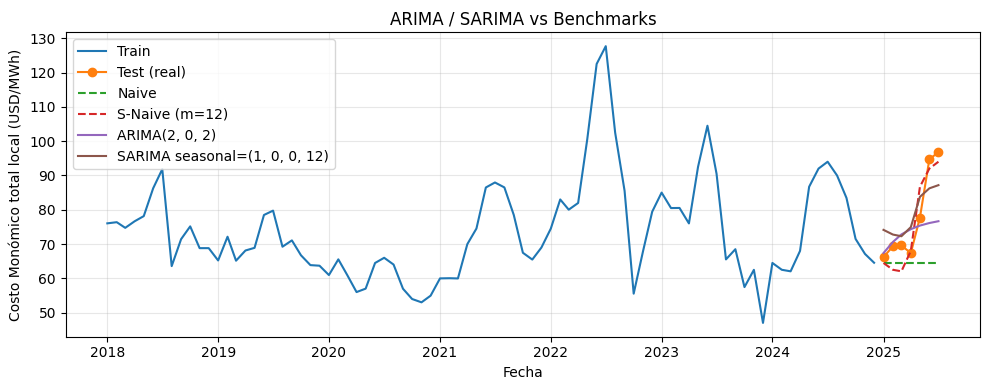


Mejor ARIMA: (2, 0, 2) | AIC: 598.9809149108586
Mejor SARIMA seasonal: (1, 0, 0, 12) | AIC: 501.3295368720463


In [ ]:
# =========================
# ARIMA / SARIMA SIN MODIFICAR df
# =========================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Config
date_col  = "Fecha"
target    = "CostoMonomico"
m = 12  # estacionalidad mensual

# --- TRABAJO EN COPIA ---
df_ts = df[[date_col, target]].copy()
df_ts[date_col] = pd.to_datetime(df_ts[date_col])
df_ts = df_ts.sort_values(date_col).set_index(date_col)
df_ts = df_ts.asfreq("MS")  # mensual inicio de mes

y = df_ts[target].astype(float)

# Split temporal (ajustá fechas si hace falta)
train_end  = "2024-12-01"
test_start = "2025-01-01"
test_end   = "2025-07-01"

y_train = y.loc[:train_end]
y_test  = y.loc[test_start:test_end]

print(f"Train: {len(y_train)} | Test: {len(y_test)}")
print("Train:", y_train.index.min().date(), "->", y_train.index.max().date())
print("Test :", y_test.index.min().date(),  "->", y_test.index.max().date())

# Métricas
def rmse(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def mase(y_train, y_true, y_pred, m=1):
    denom = np.mean(np.abs(np.asarray(y_train[m:]) - np.asarray(y_train[:-m])))
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))) / denom if denom != 0 else np.nan

def eval_metrics(name, y_true, y_pred, y_train_ref, m_for_mase=1):
    return {
        "Modelo": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "MASE": mase(y_train_ref, y_true, y_pred, m=m_for_mase),
        "R2": r2_score(y_true, y_pred),
    }

# Benchmarks
def naive_forecast(train_series, test_index):
    return pd.Series(train_series.iloc[-1], index=test_index)

def snaive_forecast(train_series, test_index, m=12):
    vals = []
    for t in test_index:
        prev = t - pd.DateOffset(months=m)
        vals.append(train_series.get(prev, train_series.iloc[-1]))
    return pd.Series(vals, index=test_index)

yhat_naive  = naive_forecast(y_train, y_test.index)
yhat_snaive = snaive_forecast(y_train, y_test.index, m=m)

# ARIMA (no estacional)
arima_orders = [(2,0,0),(0,0,2),(2,0,2)]
arima_results = {}
for order in arima_orders:
    model = SARIMAX(y_train, order=order, seasonal_order=(0,0,0,0),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    pred = res.get_forecast(steps=len(y_test)).predicted_mean
    pred.index = y_test.index
    arima_results[order] = (res, pred)

best_arima_order = min(arima_results, key=lambda k: rmse(y_test, arima_results[k][1]))
best_arima_pred  = arima_results[best_arima_order][1]

# SARIMA (m=12) con order no estacional (2,0,2)
sarima_order = (2,0,2)
seasonal_candidates = [(0,0,0,12),(1,0,0,12),(0,0,1,12),(1,0,1,12)]
sarima_results = {}
for sorder in seasonal_candidates:
    model = SARIMAX(y_train, order=sarima_order, seasonal_order=sorder,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    pred = res.get_forecast(steps=len(y_test)).predicted_mean
    pred.index = y_test.index
    sarima_results[sorder] = (res, pred)

best_sarima_sorder = min(sarima_results, key=lambda k: rmse(y_test, sarima_results[k][1]))
best_sarima_pred   = sarima_results[best_sarima_sorder][1]

# Comparativa
rows = []
rows.append(eval_metrics("Naive",            y_test, yhat_naive,  y_train, m_for_mase=1))
rows.append(eval_metrics("Naive estacional", y_test, yhat_snaive, y_train, m_for_mase=m))
rows.append(eval_metrics(f"ARIMA{best_arima_order}", y_test, best_arima_pred, y_train, m_for_mase=1))
rows.append(eval_metrics(f"SARIMA{sarima_order}, seasonal={best_sarima_sorder}", y_test, best_sarima_pred, y_train, m_for_mase=m))

metrics_df = pd.DataFrame(rows)[["Modelo","MAE","RMSE","MAPE","MASE","R2"]].sort_values("RMSE")
print("\n=== Comparativa (ordenado por RMSE) ===")
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:,.3f}"))

# Gráfico
plt.figure(figsize=(10,4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index,  y_test,  label="Test (real)", marker="o")
plt.plot(y_test.index, yhat_naive,  label="Naive", linestyle="--")
plt.plot(y_test.index, yhat_snaive, label="S-Naive (m=12)", linestyle="--")
plt.plot(y_test.index, best_arima_pred,  label=f"ARIMA{best_arima_order}")
plt.plot(y_test.index, best_sarima_pred, label=f"SARIMA seasonal={best_sarima_sorder}")
plt.title("ARIMA / SARIMA vs Benchmarks")
plt.ylabel("Costo Monómico total local (USD/MWh)"); plt.xlabel("Fecha")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# (Opcional) Info de los mejores
print("\nMejor ARIMA:", best_arima_order, "| AIC:", arima_results[best_arima_order][0].aic)
print("Mejor SARIMA seasonal:", best_sarima_sorder, "| AIC:", sarima_results[best_sarima_sorder][0].aic)


# Generacion de Base con LAGS

In [ ]:
# ==== Configuración básica ====
date_col  = 'Fecha'
target    = 'CostoMonomico'

# Lags sugeridos por tu ACF/PACF
lags_target = [1, 2, 10, 11, 12]
lags_exog   = [1, 2, 10, 11, 12]

# ==== Orden y features de mes (cíclicos, sin lags) ====
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)

# Si no tenés columna 'Mes', la creamos desde Fecha
if 'Mes' not in df.columns:
    df['Mes'] = df[date_col].dt.month

# Codificación cíclica (opcional pero recomendable)
df['mes_sin'] = np.sin(2*np.pi*df['Mes']/12)
df['mes_cos'] = np.cos(2*np.pi*df['Mes']/12)

# ==== Columnas a laguear (excluimos temporales y la target) ====
temporal_cols = {date_col, 'Mes', 'mes_sin', 'mes_cos'}
cols_to_lag = [c for c in df.columns if c not in temporal_cols and c != target]

# ==== Generación de lags ====
lagged_features = {}

# Exógenas -> nombre: <col>_lagK
for col in cols_to_lag:
    for k in lags_exog:
        lagged_features[f"{col}_lag{k}"] = df[col].shift(k)

# Target -> nombre: CostoMonomico_LAGK  (como usás en el resto del Colab)
for k in lags_target:
    lagged_features[f"CostoMonomico_lag{k}"] = df[target].shift(k)

# DataFrame de lags
df_lags = pd.DataFrame(lagged_features)

# ==== Concatenación final y limpieza ====
df_lagged = pd.concat([df, df_lags], axis=1)
df_lagged = df_lagged.dropna().reset_index(drop=True)

print(df_lagged.shape)
df_lagged.head()



(79, 70)


,Fecha,BarrilPetroleo,TempMedia,DemandaLocal+Exp,OfertaTotal,GasNatural,FuelOil,GasOil,CarbonMineral,CombustTotal,...,CombustAlt_lag1,CombustAlt_lag2,CombustAlt_lag10,CombustAlt_lag11,CombustAlt_lag12,CostoMonomico_lag1,CostoMonomico_lag2,CostoMonomico_lag10,CostoMonomico_lag11,CostoMonomico_lag12
0,2019-01-01,59.41,24.974194,11711.128097,12135.463395,4.017209,485.264036,566.540099,134.100000,267.508701,...,11.163533,6.018222,26.488278,46.869249,36.878944,68.81,68.81,74.73,76.38,76.04
1,2019-02-01,63.96,24.130357,10739.883609,11091.693776,3.943692,485.264036,566.540099,134.100000,278.551834,...,17.391065,11.163533,14.397546,26.488278,46.869249,65.22,68.81,76.65,74.73,76.38
2,2019-03-01,66.14,21.196774,10123.594771,10474.005065,3.567610,485.264036,566.525601,134.100000,185.135858,...,32.746806,17.391065,12.779675,14.397546,26.488278,72.14,65.22,78.15,76.65,74.73
3,2019-04-01,71.23,19.678333,9572.138025,9892.933904,3.455339,485.264036,566.525601,145.799984,169.547970,...,3.771707,32.746806,234.045059,12.779675,14.397546,65.15,72.14,86.27,78.15,76.65
4,2019-05-01,71.32,15.983871,10382.063338,10778.943184,4.284086,468.375618,566.525601,145.799984,219.190746,...,3.608667,3.771707,258.697765,234.045059,12.779675,68.12,65.15,91.84,86.27,78.15


# Comprobar LAGS generados

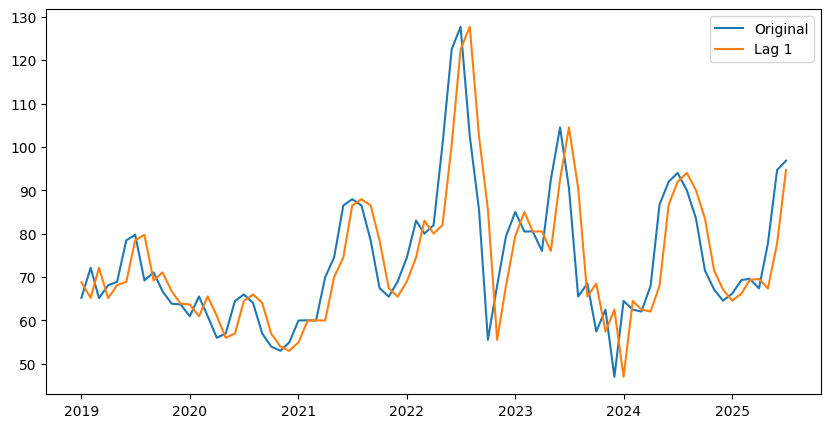

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_lagged['Fecha'], df_lagged['CostoMonomico'], label='Original')
plt.plot(df_lagged['Fecha'], df_lagged['CostoMonomico_lag1'], label='Lag 1')
plt.legend()
plt.show()

In [ ]:
# 1) Columnas originales
print("Columnas originales (13):")
print(df.columns.tolist())
print("\n")

# 2) Columnas de lags generadas
lag_cols = [c for c in df_lagged.columns if "_lag" in c]
print(f"Columnas con lags generadas ({len(lag_cols)}):")
print(lag_cols[:20], "...")  # muestra las primeras 20
print("\n")

# 3) Contar lags por variable
from collections import defaultdict

lag_count = defaultdict(int)
for col in lag_cols:
    base = col.split("_lag")[0]  # nombre base antes de "_lag"
    lag_count[base] += 1

print(" Número de lags por variable:")
for var, count in lag_count.items():
    print(f"{var}: {count} lags")


Columnas originales (13):
['Fecha', 'BarrilPetroleo', 'TempMedia', 'DemandaLocal+Exp', 'OfertaTotal', 'GasNatural', 'FuelOil', 'GasOil', 'CarbonMineral', 'CombustTotal', 'CostoMonomico', 'CombustAlt', 'Mes', 'mes_sin', 'mes_cos']


Columnas con lags generadas (55):
['BarrilPetroleo_lag1', 'BarrilPetroleo_lag2', 'BarrilPetroleo_lag10', 'BarrilPetroleo_lag11', 'BarrilPetroleo_lag12', 'TempMedia_lag1', 'TempMedia_lag2', 'TempMedia_lag10', 'TempMedia_lag11', 'TempMedia_lag12', 'DemandaLocal+Exp_lag1', 'DemandaLocal+Exp_lag2', 'DemandaLocal+Exp_lag10', 'DemandaLocal+Exp_lag11', 'DemandaLocal+Exp_lag12', 'OfertaTotal_lag1', 'OfertaTotal_lag2', 'OfertaTotal_lag10', 'OfertaTotal_lag11', 'OfertaTotal_lag12'] ...


 Número de lags por variable:
BarrilPetroleo: 5 lags
TempMedia: 5 lags
DemandaLocal+Exp: 5 lags
OfertaTotal: 5 lags
GasNatural: 5 lags
FuelOil: 5 lags
GasOil: 5 lags
CarbonMineral: 5 lags
CombustTotal: 5 lags
CombustAlt: 5 lags
CostoMonomico: 5 lags


In [ ]:
[x for x in df_lagged.columns if "CostoMonomico_lag" in x]

['CostoMonomico_lag1',
 'CostoMonomico_lag2',
 'CostoMonomico_lag10',
 'CostoMonomico_lag11',
 'CostoMonomico_lag12']

# Train en 2018-2024 Test 2025

En el procesamiento de la serie temporal se aplicaron varios pasos clave para preparar los datos de manera adecuada y evitar fuga de información (leakage). Primero, se generaron variables rezagadas (lags) de la serie objetivo y de las variables explicativas, utilizando los rezagos 1, 2, 3 y 12, con el fin de capturar tanto la dependencia inmediata como la estacionalidad anual. Luego, se incorporaron variables de estacionalidad adicionales transformando el mes en coordenadas circulares mediante funciones seno y coseno (mes_sin y mes_cos), lo que permite al modelo reconocer la continuidad entre diciembre y enero y así aprender patrones cíclicos. Para la construcción del conjunto de entrenamiento se seleccionaron exclusivamente estas variables rezagadas y de calendario, evitando el uso de variables contemporáneas que generarían información futura no disponible al momento de la predicción. Finalmente, para los modelos sensibles a la escala de las variables (como regresiones lineales tipo Ridge o Lasso), se implementó un escalado mediante StandardScaler dentro de un Pipeline de scikit-learn, garantizando que la normalización se ajuste únicamente con los datos de entrenamiento y se aplique correctamente al conjunto de prueba, evitando filtraciones de información.


## RIDGE vs Benchmark NAIVE

In [ ]:
# --- 0) Partimos de df_lagged (ya con lags [1,2,3,12]) ---
# Añadimos features de estacionalidad (opcional pero útil)
df_lagged['mes'] = df_lagged['Fecha'].dt.month
df_lagged['mes_sin'] = np.sin(2*np.pi*df_lagged['mes']/12)
df_lagged['mes_cos'] = np.cos(2*np.pi*df_lagged['mes']/12)

# --- 1) Split temporal por año ---
train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

# Por claridad, definimos target y features SIN contemporáneas (evita fuga de info)
target_col = 'CostoMonomico'
lag_cols = [c for c in df_lagged.columns if '_lag' in c]  # todos los rezagos
cal_cols = ['mes_sin', 'mes_cos']                          # estacionalidad (opc)
feature_cols = lag_cols + cal_cols

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

print("Train:", X_train.shape, "Test:", X_test.shape)

# --- 2) Modelo base (Ridge) con escalado sin leakage ---
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=1.0, random_state=0))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 3) Métricas ---
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test).mean() * 100)

# MASE: escalamos por el MAE del naive insample en TRAIN
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))
mase = mae / mae_naive_train

print(f"Ridge → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | MASE: {mase:.3f}")

## R2
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

# --- 4) Benchmark Naïve (y_t ≈ y_{t-1}) en TEST ---
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']

mae_naive  = mean_absolute_error(y_test, naive_pred)
mse_naive  = mean_squared_error(y_test, naive_pred)
rmse_naive = np.sqrt(mse_naive)

# Métricas adicionales para el Naïve
mape_naive = (np.abs((y_test - naive_pred) / y_test).mean() * 100)

# MASE del Naïve: mismo denominador que usaste para el modelo (MAE del naive in-sample en TRAIN)
mase_den = mae_naive_train if mae_naive_train != 0 else np.nan
mase_naive = mae_naive / mase_den

r2_naive = r2_score(y_test, naive_pred)

print(f"Naïve → MAE: {mae_naive:.3f} | RMSE: {rmse_naive:.3f} | "
      f"MAPE: {mape_naive:.2f}% | MASE: {mase_naive:.3f} | R²: {r2_naive:.3f}")

# --- 5) Benchmark Naïve estacional (y_t ≈ y_{t-12}) en TEST ---
naive_seasonal_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag12']

mae_naive_seasonal  = mean_absolute_error(y_test, naive_seasonal_pred)
mse_naive_seasonal  = mean_squared_error(y_test, naive_seasonal_pred)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
mape_naive_seasonal = (np.abs((y_test - naive_seasonal_pred) / y_test).mean() * 100)

# Denominador para MASE estacional = error medio de un naive estacional in-sample
if len(y_train) > 12:
    mae_naive_seasonal_train = np.mean(np.abs(y_train.values[12:] - y_train.values[:-12]))
    mase_naive_seasonal = mae_naive_seasonal / mae_naive_seasonal_train
else:
    mase_naive_seasonal = np.nan

r2_naive_seasonal = r2_score(y_test, naive_seasonal_pred)

print(f"Naïve estacional (lag12) → MAE: {mae_naive_seasonal:.3f} | RMSE: {rmse_naive_seasonal:.3f} | "
      f"MAPE: {mape_naive_seasonal:.2f}% | MASE: {mase_naive_seasonal:.3f} | R²: {r2_naive_seasonal:.3f}")


Train: (72, 57) Test: (7, 57)
Ridge → MAE: 4.497 | RMSE: 6.329 | MAPE: 5.61% | MASE: 0.629
R²: 0.7274351643494715
Naïve → MAE: 5.243 | RMSE: 7.714 | MAPE: 6.30% | MASE: 0.733 | R²: 0.595
Naïve estacional (lag12) → MAE: 4.453 | RMSE: 5.377 | MAPE: 5.92% | MASE: 0.317 | R²: 0.803


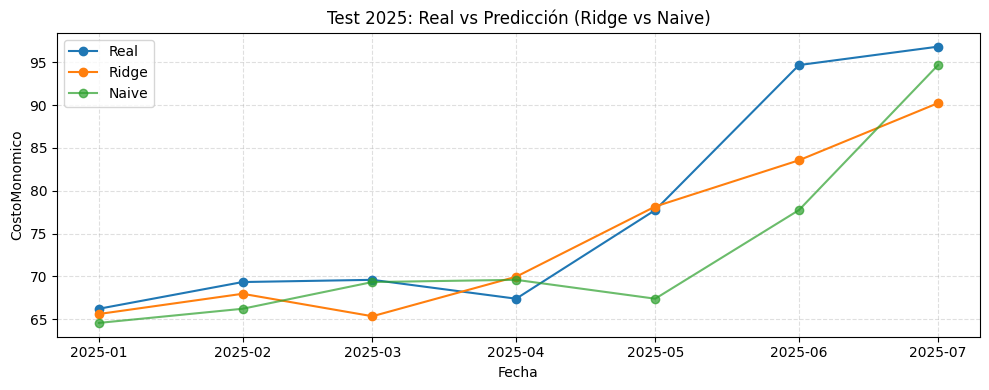

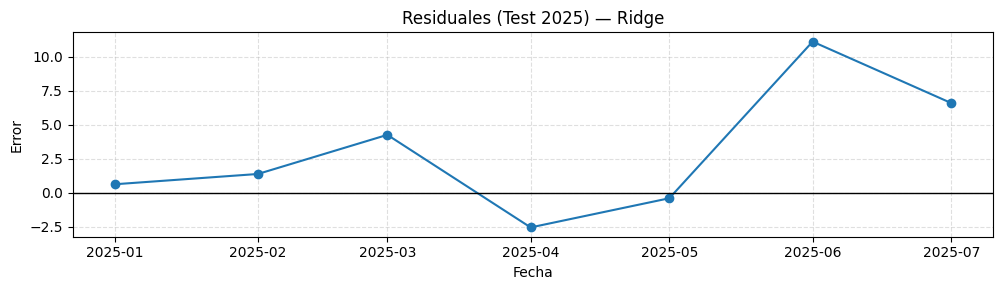

In [ ]:
fechas_test = df_lagged.loc[test_mask, 'Fecha']

plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='Ridge')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naive')
plt.title('Test 2025: Real vs Predicción (Ridge vs Naive)')
plt.xlabel('Fecha'); plt.ylabel(target_col)
plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

# (Opcional) Residuales del Ridge en Test
res_test = y_test.values - y_pred
plt.figure(figsize=(10,3))
plt.plot(fechas_test, res_test, marker='o')
plt.axhline(0, color='k', lw=1)
plt.title('Residuales (Test 2025) — Ridge')
plt.xlabel('Fecha'); plt.ylabel('Error')
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Explicativo del RIDGE

🔎 Coeficientes del modelo Ridge (ordenados por importancia):


,Coeficiente
FuelOil_lag10,7.091723
GasNatural_lag12,5.446500
CarbonMineral_lag11,-5.408057
CarbonMineral_lag1,-5.011525
TempMedia_lag11,-3.996255
GasOil_lag10,-3.747192
CarbonMineral_lag10,3.679547
mes_sin,3.567987
CostoMonomico_lag2,-3.489094
CarbonMineral_lag12,-3.441794


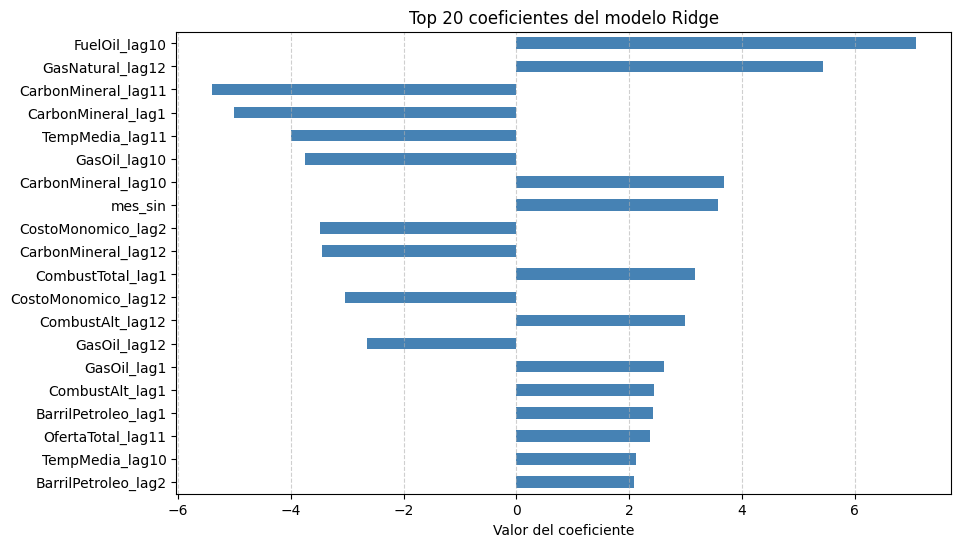

In [ ]:
# Extraer el modelo Ridge entrenado desde el pipeline
ridge_model = model.named_steps['reg']

# Coeficientes asociados a cada feature
coefs = pd.Series(ridge_model.coef_, index=feature_cols)

# Ordenarlos por importancia absoluta
coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)

# Mostrar tabla
print("🔎 Coeficientes del modelo Ridge (ordenados por importancia):")
display(coefs_sorted.to_frame("Coeficiente"))

# Gráfico de barras
plt.figure(figsize=(10,6))
coefs_sorted.head(20).plot(kind="barh", color="steelblue")
plt.title("Top 20 coeficientes del modelo Ridge")
plt.xlabel("Valor del coeficiente")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

## RIDGE con GRIDSEARCH vs Benchmark NAIVE

Train: (72, 57) Test: (7, 57)

Mejor alpha: 100.0
CV (MAE) promedio: 8.76361810276747

Ridge (GridSearch) → MAE: 4.922 | RMSE: 6.490 | MAPE: 5.89% | MASE: 0.688 | R²: 0.713
Naïve → MAE: 5.243 | RMSE: 7.714


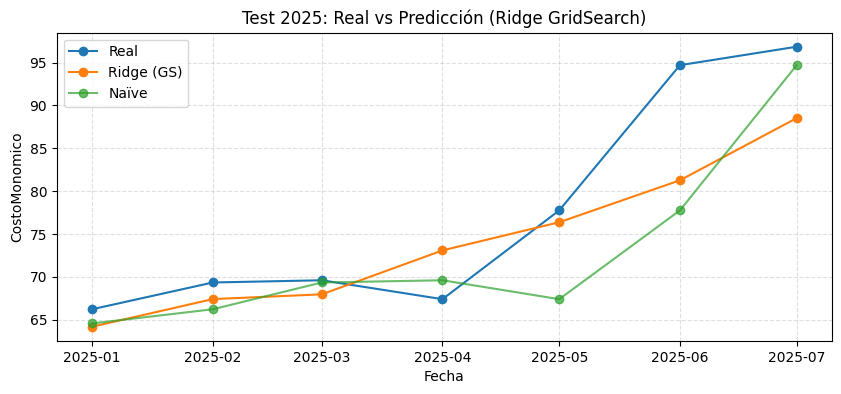


Top 20 coeficientes por importancia absoluta:


,Coeficiente
CombustAlt_lag1,1.410524
CostoMonomico_lag1,1.293354
CombustTotal_lag1,1.292137
BarrilPetroleo_lag1,1.228042
TempMedia_lag11,-1.030996
BarrilPetroleo_lag2,0.973316
TempMedia_lag12,-0.924216
GasNatural_lag11,0.891327
mes_cos,-0.812434
GasNatural_lag12,0.762272


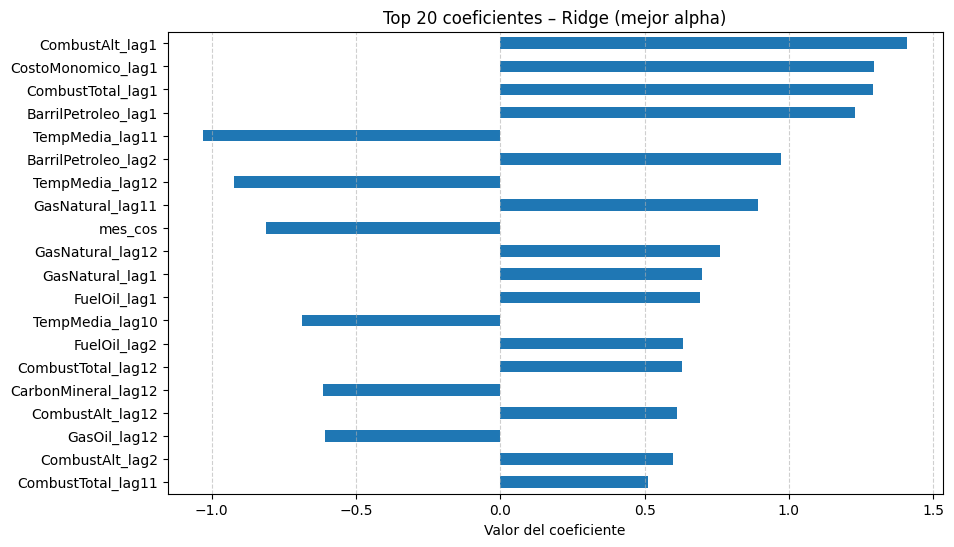

In [ ]:
# ======================
# 0) Preparación de datos
# ======================
target_col = 'CostoMonomico'

# features: TODOS los lags + estacionalidad (mes_sin/cos) — sin contemporáneas
lag_cols = [c for c in df_lagged.columns if '_lag' in c]
cal_cols = ['mes_sin', 'mes_cos']   # si ya las creaste
feature_cols = lag_cols + cal_cols

train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

print("Train:", X_train.shape, "Test:", X_test.shape)

# ==========================================
# 1) Pipeline + GridSearch con validación T.S.
# ==========================================
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', Ridge(random_state=0))
])

# Rango de alphas (podés ampliar/reducir)
param_grid = {
    'reg__alpha': np.logspace(-3, 3, 13)  # 0.001 ... 1000
}

# TimeSeriesSplit (p.ej., 5 particiones)
tscv = TimeSeriesSplit(n_splits=5)

# Usamos MAE como métrica de selección (negativo porque sklearn maximiza)
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True,          # reentrena con el mejor alpha en TODO el train
    verbose=0
)

gcv.fit(X_train, y_train)

print("\nMejor alpha:", gcv.best_params_['reg__alpha'])
print("CV (MAE) promedio:", -gcv.best_score_)

# ===========================
# 2) Evaluación en TEST (2025)
# ===========================
y_pred = gcv.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test).mean() * 100)
# MASE: escalar por el MAE del naïve INSAMPLE en TRAIN
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))
mase = mae / mae_naive_train
r2   = r2_score(y_test, y_pred)

print(f"\nRidge (GridSearch) → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | MASE: {mase:.3f} | R²: {r2:.3f}")

# ===========================
# 3) Baseline Naïve en TEST
# ===========================
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']
mae_n  = mean_absolute_error(y_test, naive_pred)
rmse_n = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naïve → MAE: {mae_n:.3f} | RMSE: {rmse_n:.3f}")

# ===========================
# 4) Gráfico comparativo (opcional)
# ===========================
fechas_test = df_lagged.loc[test_mask, 'Fecha']

plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='Ridge (GS)')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naïve')
plt.title('Test 2025: Real vs Predicción (Ridge GridSearch)')
plt.xlabel('Fecha'); plt.ylabel(target_col); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.show()

# ===========================
# 5) Coeficientes del mejor modelo
# ===========================
best_ridge = gcv.best_estimator_.named_steps['reg']
coefs = pd.Series(best_ridge.coef_, index=feature_cols)
coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)

print("\nTop 20 coeficientes por importancia absoluta:")
display(coefs_sorted.head(20).to_frame("Coeficiente"))

plt.figure(figsize=(10,6))
coefs_sorted.head(20).plot(kind="barh")
plt.title("Top 20 coeficientes – Ridge (mejor alpha)")
plt.xlabel("Valor del coeficiente")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

## LightGBM vs Benchmark Naive

In [ ]:
!pip install lightgbm

In [ ]:
# ========= 0) Datos/Features (como venías) =========
target_col = 'CostoMonomico'
lag_cols = [c for c in df_lagged.columns if '_lag' in c]
cal_cols = ['mes_sin', 'mes_cos']  # estacionalidad
feature_cols = lag_cols + cal_cols

train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (72, 57) Test: (7, 57)


In [ ]:
# ========= 1) Modelo base LGBM =========
# Nota: desactivo bagging por si te preocupa la muestra temporal.
base_params = dict(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,            # = bagging_fraction
    subsample_freq=0,         # sin bagging por iteración
    colsample_bytree=0.8,     # = feature_fraction
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=0,
    n_jobs=-1
)
lgbm = LGBMRegressor(**base_params)

# ========= 2) Búsqueda de hiperparámetros con CV temporal =========
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    "num_leaves":        [15, 31, 63, 127],
    "learning_rate":     [0.03, 0.05, 0.07, 0.1],
    "n_estimators":      [400, 700, 1000, 1500, 2000],
    "min_child_samples": [10, 20, 30, 50],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    # Si NO te preocupa el submuestreo, podés permitirlo:
    # "subsample":        [0.7, 0.85, 1.0],
    # "subsample_freq":   [0, 1],
    "reg_alpha":         [0.0, 0.1, 0.5],
    "reg_lambda":        [0.0, 0.1, 0.5, 1.0],
    "max_depth":         [-1, 6, 8, 10]
}

rs = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,                    # podés subir/bajar según tiempo
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    refit=True
)

rs.fit(X_train, y_train)
print("Mejores params:", rs.best_params_)
print("CV MAE (negativo):", rs.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1342
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 57
[LightGBM] [Info] Start training from score 73.477637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBM → MAE: 3.885 | RMSE: 4.860 | MAPE: 4.72% | MASE: 0.543 | R²: 0.839
Naïve simple (lag1) → MAE: 5.243 | RMSE: 7.714 | MAPE: 6.30% | MASE: 0.733 | R²: 0.595
Naïve estacional (lag12) → MAE: 5.243 | RMSE: 7.714 | MAPE: 6.30% | MASE: 0.373 | R²: 0.595


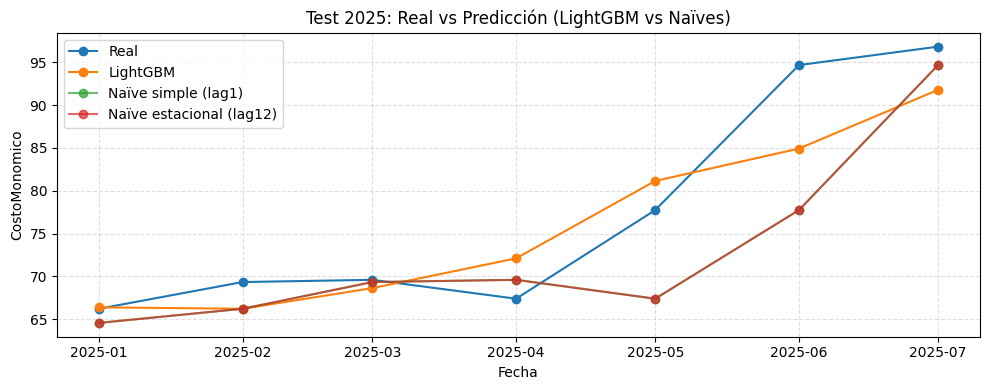

In [ ]:
# ========= 3) Evaluación en TEST (2025) =========
best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = (np.abs((y_test - y_pred)/y_test).mean() * 100)
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))  # denom MASE (naïve simple in-sample)
mase = mae / mae_naive_train
r2   = r2_score(y_test, y_pred)

print(f"LGBM → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | MASE: {mase:.3f} | R²: {r2:.3f}")

# ========= 3b) Baselines =========

# Naïve simple (lag1)
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']
mae_n  = mean_absolute_error(y_test, naive_pred)
rmse_n = np.sqrt(mean_squared_error(y_test, naive_pred))
mape_n = (np.abs((y_test - naive_pred) / y_test).mean() * 100)
mase_n = mae_n / mae_naive_train
r2_n   = r2_score(y_test, naive_pred)

print(f"Naïve simple (lag1) → MAE: {mae_n:.3f} | RMSE: {rmse_n:.3f} | "
      f"MAPE: {mape_n:.2f}% | MASE: {mase_n:.3f} | R²: {r2_n:.3f}")

# Naïve estacional (lag12)
s = 12
naive_seasonal_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']

mae_ns  = mean_absolute_error(y_test, naive_seasonal_pred)
rmse_ns = np.sqrt(mean_squared_error(y_test, naive_seasonal_pred))
mape_ns = (np.abs((y_test - naive_seasonal_pred) / y_test).mean() * 100)

# Denominador para MASE estacional = MAE del naïve estacional in-sample (TRAIN)
if len(y_train) > s:
    mae_naive_seasonal_train = np.mean(np.abs(y_train.values[s:] - y_train.values[:-s]))
    mase_ns = mae_ns / mae_naive_seasonal_train
else:
    mae_naive_seasonal_train = np.nan
    mase_ns = np.nan

r2_ns = r2_score(y_test, naive_seasonal_pred)

print(f"Naïve estacional (lag{s}) → MAE: {mae_ns:.3f} | RMSE: {rmse_ns:.3f} | "
      f"MAPE: {mape_ns:.2f}% | MASE: {mase_ns:.3f} | R²: {r2_ns:.3f}")

# ========= 4) Gráfico comparativo =========
fechas_test = df_lagged.loc[test_mask, 'Fecha']

plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='LightGBM')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naïve simple (lag1)')
plt.plot(fechas_test, naive_seasonal_pred.values, marker='o', alpha=0.7, label='Naïve estacional (lag12)')
plt.title('Test 2025: Real vs Predicción (LightGBM vs Naïves)')
plt.xlabel('Fecha'); plt.ylabel(target_col); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Light GBM con Bagging vs Benchmark NAIVE

In [ ]:
target_col = 'CostoMonomico'
lag_cols = [c for c in df_lagged.columns if '_lag' in c]
cal_cols = ['mes_sin', 'mes_cos']  # si las creaste
feature_cols = lag_cols + cal_cols

train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

In [ ]:
# === 1) Definir modelo base con bagging activado ===
base_params = dict(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,        # bagging ON
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=0,
    n_jobs=-1
)
lgbm = LGBMRegressor(**base_params)

# === 2) Búsqueda con CV temporal ===
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    "num_leaves":        [15, 31, 63, 127],
    "learning_rate":     [0.03, 0.05, 0.07, 0.1],
    "n_estimators":      [400, 700, 1000, 1500, 2000],
    "min_child_samples": [10, 20, 30, 50],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    "subsample":         [0.7, 0.85, 1.0],
    "subsample_freq":    [0, 1],
    "reg_alpha":         [0.0, 0.1, 0.5],
    "reg_lambda":        [0.0, 0.1, 0.5, 1.0],
    "max_depth":         [-1, 6, 8, 10]
}

rs = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    refit=True
)

# >>> ENTRENAR LA BÚSQUEDA <<<
rs.fit(X_train, y_train)

print("Mejores params:", rs.best_params_)
print("CV MAE (negativo):", rs.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1342
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 57
[LightGBM] [Info] Start training from score 73.477637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LightGBM → MAE: 3.837 | RMSE: 4.807 | MAPE: 4.76% | MASE: 0.536 | R²: 0.843
Naïve → MAE: 5.243 | RMSE: 7.714
Naïve estacional (lag12) → MAE: 4.453 | RMSE: 5.377 | MAPE: 5.92% | MASE: 0.317 | R²: 0.803


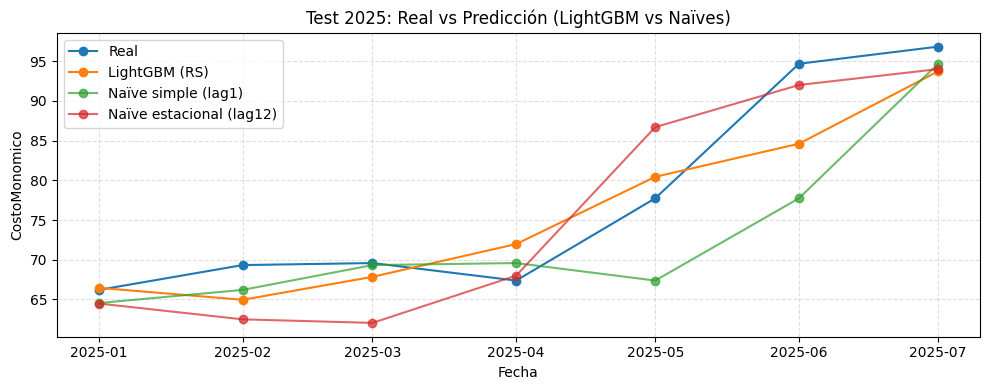

In [ ]:
# === 3) Evaluación en TEST (2025) ===
# Compatibilidad por si tu sklearn usa otro atributo
best_model = rs.best_estimator_ if hasattr(rs, "best_estimator_") else rs.best_estimator
y_pred = best_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = (np.abs((y_test - y_pred) / y_test).mean() * 100)
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))
mase = mae / mae_naive_train
r2   = r2_score(y_test, y_pred)

print(f"LightGBM → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | MASE: {mase:.3f} | R²: {r2:.3f}")

# Baseline Naïve
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']
mae_n  = mean_absolute_error(y_test, naive_pred)
rmse_n = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naïve → MAE: {mae_n:.3f} | RMSE: {rmse_n:.3f}")

# ===== Naïve estacional (lag 12) =====
s = 12
# Asegurar columna lag12 por si acaso
if 'CostoMonomico_lag12' not in df_lagged.columns:
    df_lagged['CostoMonomico_lag12'] = df_lagged[target_col].shift(s)

naive_seasonal_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag12']

mae_ns  = mean_absolute_error(y_test, naive_seasonal_pred)
rmse_ns = np.sqrt(mean_squared_error(y_test, naive_seasonal_pred))
mape_ns = (np.abs((y_test - naive_seasonal_pred) / y_test).mean() * 100)

# MASE estacional: denom = MAE del naïve estacional in-sample (TRAIN)
if len(y_train) > s:
    mae_naive_seasonal_train = np.mean(np.abs(y_train.values[s:] - y_train.values[:-s]))
    mase_ns = mae_ns / mae_naive_seasonal_train
else:
    mae_naive_seasonal_train = np.nan
    mase_ns = np.nan

r2_ns = r2_score(y_test, naive_seasonal_pred)

print(f"Naïve estacional (lag{s}) → MAE: {mae_ns:.3f} | RMSE: {rmse_ns:.3f} | "
      f"MAPE: {mape_ns:.2f}% | MASE: {mase_ns:.3f} | R²: {r2_ns:.3f}")

# === 4) Gráfico comparativo (incluye Naïve estacional) ===
fechas_test = df_lagged.loc[test_mask, 'Fecha']
plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='LightGBM (RS)')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naïve simple (lag1)')
plt.plot(fechas_test, naive_seasonal_pred.values, marker='o', alpha=0.7, label='Naïve estacional (lag12)')
plt.title('Test 2025: Real vs Predicción (LightGBM vs Naïves)')
plt.xlabel('Fecha'); plt.ylabel(target_col); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

## XGBoost vs. Benchmark NAIVE

In [ ]:
!pip install xgboost

In [ ]:
# ======================
# 0) Datos y features
# ======================
# (Si ya los definiste arriba, podés omitir este bloque.)
target_col = 'CostoMonomico'
lag_cols   = [c for c in df_lagged.columns if '_lag' in c]
cal_cols   = ['mes_sin', 'mes_cos']  # estacionalidad
feature_cols = lag_cols + cal_cols

train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (72, 57) Test: (7, 57)


In [ ]:
# ======================
# 1) Modelo base XGBoost
# ======================
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

base_params = dict(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    gamma=0.0,
    subsample=1.0,           # sin submuestreo (NO bootstrap) por defecto
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=0,
    n_jobs=-1,
    tree_method='hist'       # rápido/estable en Colab
)
xgb = XGBRegressor(**base_params)

# ======================
# 2) Búsqueda con CV temporal
# ======================
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    "n_estimators":      [400, 700, 1000, 1500, 2000],
    "learning_rate":     [0.03, 0.05, 0.07, 0.1],
    "max_depth":         [3, 4, 6, 8, 10],
    "min_child_weight":  [1, 3, 5, 10],
    "gamma":             [0.0, 0.1, 0.3],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    # Submuestreo opcional (NO es bootstrap; se hace dentro del train-fold):
    "subsample":         [0.7, 0.85, 1.0],
    "reg_alpha":         [0.0, 0.1, 0.5],
    "reg_lambda":        [0.0, 0.1, 0.5, 1.0],
}

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    refit=True
)

# >>> ENTRENAR LA BÚSQUEDA <<<
rs.fit(X_train, y_train)

print("Mejores params (XGB):", rs.best_params_)
print("CV MAE (negativo):", rs.best_score_)

Mejores params (XGB): {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.07, 'gamma': 0.0, 'colsample_bytree': 1.0}
CV MAE (negativo): -8.804670484858198


XGBoost → MAE: 6.562 | RMSE: 7.884 | MAPE: 8.49% | MASE: 0.917 | R²: 0.577
Naïve simple (lag1) → MAE: 5.243 | RMSE: 7.714 | MAPE: 6.30% | MASE: 0.733 | R²: 0.595
Naïve estacional (lag12) → MAE: 4.453 | RMSE: 5.377 | MAPE: 5.92% | MASE: 0.317 | R²: 0.803


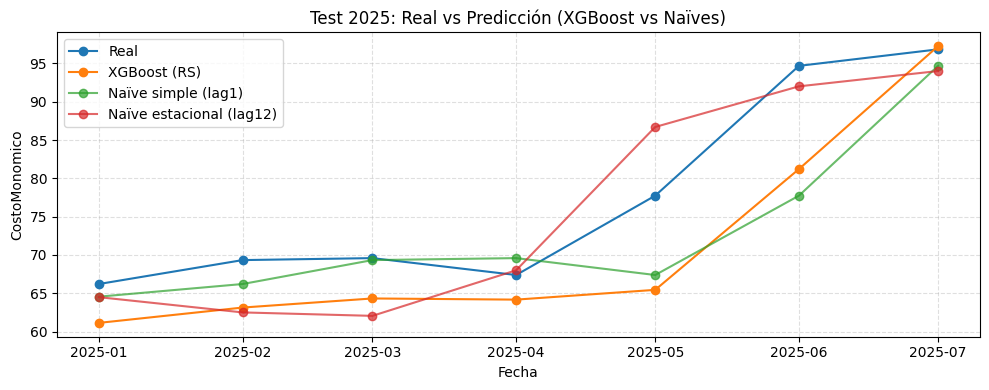

In [ ]:
# ======================
# 3) Evaluación en TEST (2025)
# ======================
best_model = rs.best_estimator_ if hasattr(rs, "best_estimator_") else rs.best_estimator
y_pred = best_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = (np.abs((y_test - y_pred) / y_test).mean() * 100)
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))
mase = mae / mae_naive_train
r2   = r2_score(y_test, y_pred)

print(f"XGBoost → MAE: {mae:.3f} | RMSE: {rmse:.3f} | "
      f"MAPE: {mape:.2f}% | MASE: {mase:.3f} | R²: {r2:.3f}")

# ======================
# 3b) Baselines
# ======================

# Naïve simple (lag1)
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']
mae_n  = mean_absolute_error(y_test, naive_pred)
rmse_n = np.sqrt(mean_squared_error(y_test, naive_pred))
mape_n = (np.abs((y_test - naive_pred) / y_test).mean() * 100)
mase_n = mae_n / mae_naive_train
r2_n   = r2_score(y_test, naive_pred)

print(f"Naïve simple (lag1) → MAE: {mae_n:.3f} | RMSE: {rmse_n:.3f} | "
      f"MAPE: {mape_n:.2f}% | MASE: {mase_n:.3f} | R²: {r2_n:.3f}")

# Naïve estacional (lag12)
s = 12
naive_seasonal_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag12']
mae_ns  = mean_absolute_error(y_test, naive_seasonal_pred)
rmse_ns = np.sqrt(mean_squared_error(y_test, naive_seasonal_pred))
mape_ns = (np.abs((y_test - naive_seasonal_pred) / y_test).mean() * 100)

if len(y_train) > s:
    mae_naive_seasonal_train = np.mean(np.abs(y_train.values[s:] - y_train.values[:-s]))
    mase_ns = mae_ns / mae_naive_seasonal_train
else:
    mase_ns = np.nan

r2_ns = r2_score(y_test, naive_seasonal_pred)

print(f"Naïve estacional (lag{s}) → MAE: {mae_ns:.3f} | RMSE: {rmse_ns:.3f} | "
      f"MAPE: {mape_ns:.2f}% | MASE: {mase_ns:.3f} | R²: {r2_ns:.3f}")

# ======================
# 4) Gráfico comparativo
# ======================
fechas_test = df_lagged.loc[test_mask, 'Fecha']
plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='XGBoost (RS)')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naïve simple (lag1)')
plt.plot(fechas_test, naive_seasonal_pred.values, marker='o', alpha=0.7, label='Naïve estacional (lag12)')
plt.title('Test 2025: Real vs Predicción (XGBoost vs Naïves)')
plt.xlabel('Fecha'); plt.ylabel(target_col); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Support Vector Regressor vs benchmark NAIVE

In [ ]:
# ======================
# 0) Datos y features
# ======================
# (Si ya los definiste arriba, podés omitir este bloque.)
target_col = 'CostoMonomico'
lag_cols   = [c for c in df_lagged.columns if '_lag' in c]
cal_cols   = ['mes_sin', 'mes_cos']  # estacionalidad
feature_cols = lag_cols + cal_cols

train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (72, 57) Test: (7, 57)


In [ ]:
# ======================
# 1) Modelo base SVR (en Pipeline con escalado)
# ======================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

# ======================
# 2) Búsqueda con CV temporal (sin fuga)
# ======================
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    'svr__C':       [0.1, 0.3, 1, 3, 10, 30, 100, 300],
    'svr__epsilon': [0.01, 0.03, 0.05, 0.1, 0.2, 0.5],
    'svr__gamma':   ['scale', 'auto', 0.001, 0.01, 0.1, 1.0],
    # 'svr__kernel': ['rbf']  # dejamos fijo rbf; si querés probar 'poly', agregalo
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    random_state=0,
    verbose=0,
    refit=True
)

# >>> ENTRENAR LA BÚSQUEDA <<<
rs.fit(X_train, y_train)

print("Mejores params (SVR):", rs.best_params_)
print("CV MAE (negativo):", rs.best_score_)


Mejores params (SVR): {'svr__gamma': 0.001, 'svr__epsilon': 0.2, 'svr__C': 300}
CV MAE (negativo): -9.523695645357495


SVR → MAE: 3.850 | RMSE: 5.270 | MAPE: 4.56% | MASE: 0.538 | R²: 0.811
Naïve simple (lag1) → MAE: 5.243 | RMSE: 7.714
Naïve estacional (lag12) → MAE: 4.453 | RMSE: 5.377 | MAPE: 5.92% | MASE: 0.317 | R²: 0.803


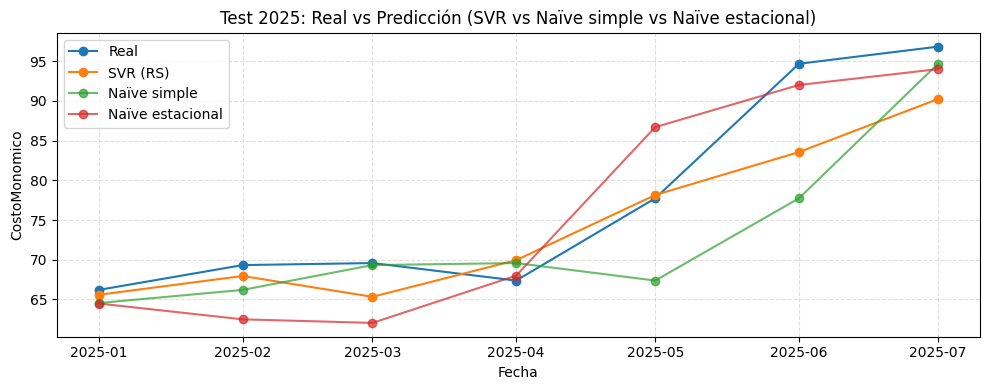

In [ ]:
# ======================
# 3) Evaluación en TEST (2025)
# ======================
best_model = rs.best_estimator_ if hasattr(rs, "best_estimator_") else rs.best_estimator
y_pred = best_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = (np.abs((y_test - y_pred) / y_test).mean() * 100)

# MASE respecto a naive simple in-sample
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))
mase = mae / mae_naive_train

r2   = r2_score(y_test, y_pred)

print(f"SVR → MAE: {mae:.3f} | RMSE: {rmse:.3f} | "
      f"MAPE: {mape:.2f}% | MASE: {mase:.3f} | R²: {r2:.3f}")

# ======================
# 3b) Baselines
# ======================

# Naïve simple (lag1)
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']
mae_n  = mean_absolute_error(y_test, naive_pred)
rmse_n = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naïve simple (lag1) → MAE: {mae_n:.3f} | RMSE: {rmse_n:.3f}")

# Naïve estacional (lag12)
s = 12
naive_seasonal_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag12']

mae_ns  = mean_absolute_error(y_test, naive_seasonal_pred)
rmse_ns = np.sqrt(mean_squared_error(y_test, naive_seasonal_pred))
mape_ns = (np.abs((y_test - naive_seasonal_pred) / y_test).mean() * 100)

# MASE estacional: denom = MAE del naive estacional in-sample (TRAIN)
if len(y_train) > s:
    mae_naive_seasonal_train = np.mean(np.abs(y_train.values[s:] - y_train.values[:-s]))
    mase_ns = mae_ns / mae_naive_seasonal_train
else:
    mae_naive_seasonal_train = np.nan
    mase_ns = np.nan

r2_ns = r2_score(y_test, naive_seasonal_pred)

print(f"Naïve estacional (lag{s}) → MAE: {mae_ns:.3f} | RMSE: {rmse_ns:.3f} | "
      f"MAPE: {mape_ns:.2f}% | MASE: {mase_ns:.3f} | R²: {r2_ns:.3f}")
# ======================
# 4) Gráfico comparativo
# ======================
fechas_test = df_lagged.loc[test_mask, 'Fecha']
plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='SVR (RS)')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naïve simple')
plt.plot(fechas_test, naive_seasonal_pred.values, marker='o', alpha=0.7, label='Naïve estacional')
plt.title('Test 2025: Real vs Predicción (SVR vs Naïve simple vs Naïve estacional)')
plt.xlabel('Fecha'); plt.ylabel(target_col)
plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Explicativo de SVR


Top 20 features por Permutation Importance (media ± std):


,importance_mean,importance_std
TempMedia_lag11,1.342822,0.901844
GasNatural_lag12,0.675479,0.448925
CombustTotal_lag1,0.642238,0.430088
CostoMonomico_lag1,0.551909,0.510661
CombustAlt_lag1,0.516810,0.459664
CombustAlt_lag12,0.359597,0.302679
CostoMonomico_lag11,0.334373,0.253909
CombustTotal_lag12,0.290274,0.227129
CombustAlt_lag11,0.287473,0.212410
GasNatural_lag11,0.241624,0.363487


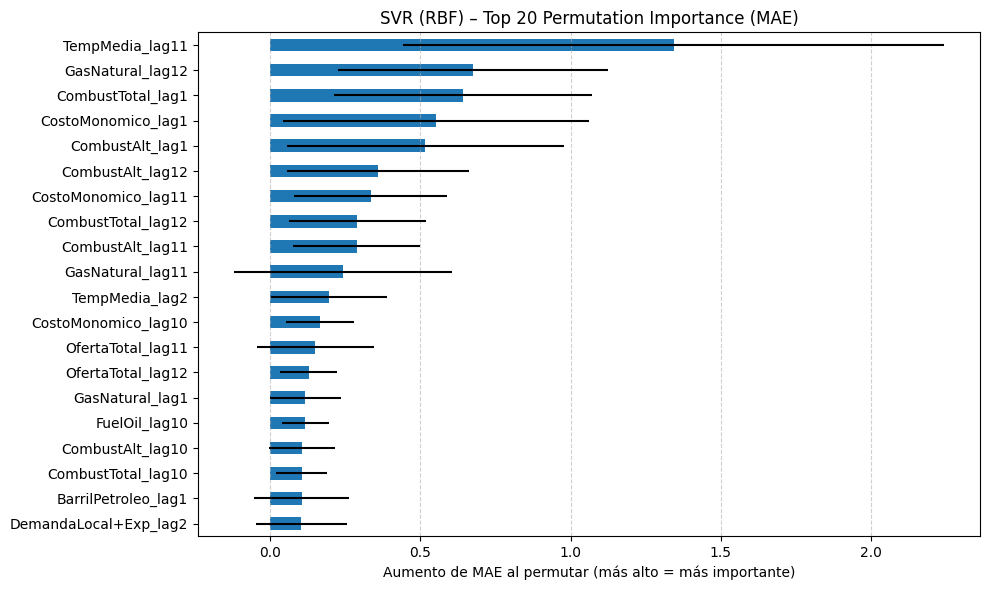

In [ ]:
from sklearn.inspection import permutation_importance

# Importancia por permutación usando MAE (negativo porque sklearn maximiza)
r = permutation_importance(
    best_model,
    X_test, y_test,
    scoring='neg_mean_absolute_error',
    n_repeats=30,
    random_state=0,
    n_jobs=-1
)

imp_mean = pd.Series(r.importances_mean, index=feature_cols)
imp_std  = pd.Series(r.importances_std,  index=feature_cols)

imp_sorted = imp_mean.sort_values(ascending=False)

print("\nTop 20 features por Permutation Importance (media ± std):")
display(pd.DataFrame({
    "importance_mean": imp_sorted.head(20),
    "importance_std": imp_std.loc[imp_sorted.head(20).index]
}))

plt.figure(figsize=(10,6))
imp_sorted.head(20).sort_values().plot(kind="barh", xerr=imp_std.loc[imp_sorted.head(20).index])
plt.title("SVR (RBF) – Top 20 Permutation Importance (MAE)")
plt.xlabel("Aumento de MAE al permutar (más alto = más importante)")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
pip install shap

PermutationExplainer explainer: 8it [00:16,  2.41s/it]
/tmp/ipython-input-2212954700.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_take, show=False)  # show=False si estás en bucles


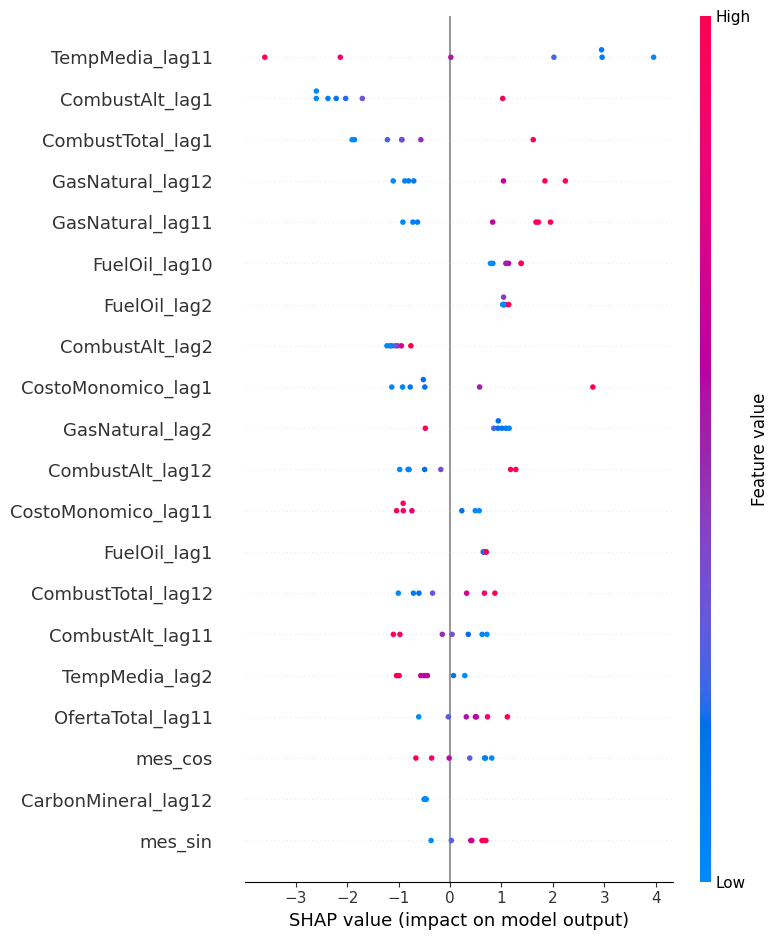


Top 20 features por mean(|SHAP|):


,mean|SHAP|
TempMedia_lag11,2.519357
CombustAlt_lag1,2.076560
CombustTotal_lag1,1.290499
GasNatural_lag12,1.231389
GasNatural_lag11,1.206281
FuelOil_lag10,1.101897
FuelOil_lag2,1.060003
CombustAlt_lag2,1.045153
CostoMonomico_lag1,1.026777
GasNatural_lag2,0.922088


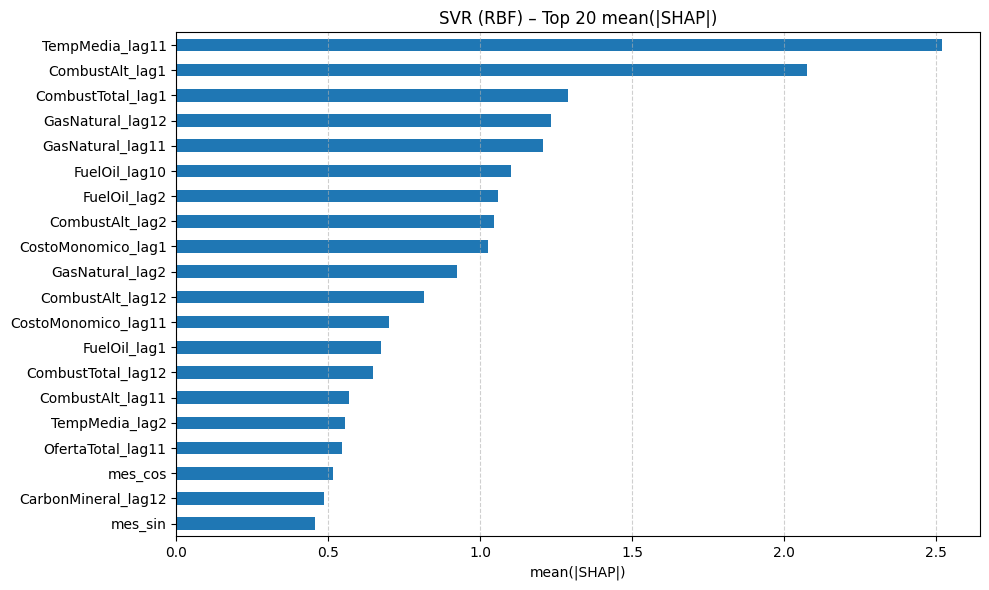

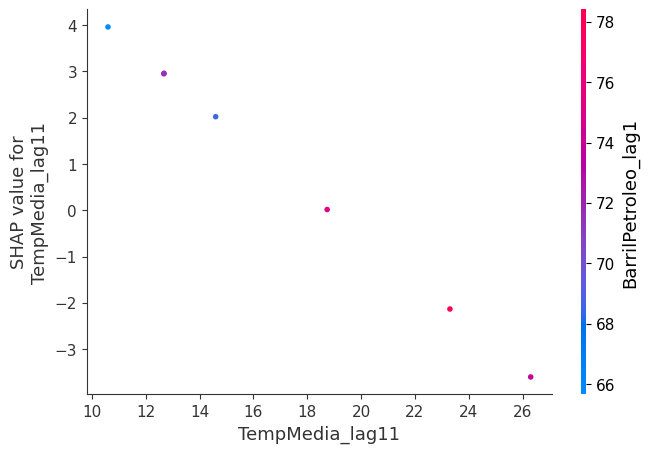

In [ ]:
# ================= SHAP para SVR (Pipeline) =================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

shap.initjs()

# Asegurar mismo orden de columnas que el entrenamiento
X_bg   = X_train[feature_cols].sample(n=min(300, len(X_train)), random_state=0)   # background
X_take = X_test[feature_cols].sample(n=min(200, len(X_test)), random_state=0)     # a explicar

# Masker + Explainer (auto-detecta KernelExplainer para funciones arbitrarias)
masker = shap.maskers.Independent(X_bg)
# Si tu pipeline acepta DataFrames (como es el caso), podés pasar directamente .predict
explainer = shap.Explainer(best_model.predict, masker, feature_names=feature_cols)

# Calculamos los valores SHAP
shap_values = explainer(X_take)  # objeto Explanation
# Para summary_plot, podés pasar directamente 'shap_values' y 'X_take'
shap.summary_plot(shap_values, X_take, show=False)  # show=False si estás en bucles
plt.tight_layout()
plt.show()

# ===== Ranking global por importancia: mean(|SHAP|) =====
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=feature_cols).sort_values(ascending=False)

print("\nTop 20 features por mean(|SHAP|):")
display(shap_importance.head(20).to_frame("mean|SHAP|"))

plt.figure(figsize=(10,6))
shap_importance.head(20).sort_values().plot(kind="barh")
plt.title("SVR (RBF) – Top 20 mean(|SHAP|)")
plt.xlabel("mean(|SHAP|)")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ===== Dependencia SHAP de una feature clave =====
# Si ya tenés 'imp_sorted' (Permutation Importance), usá esa. Si no, usamos la top por SHAP.
feat = shap_importance.index[0]
shap.dependence_plot(feat, shap_values.values, X_take, feature_names=feature_cols)


# Train Test con Expanding Window

## SVR

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración
n_splits = 5   # número de folds que querés simular
min_train_size = int(len(X_train) * 0.5)  # arranca con 50% de train, podés ajustar

# Índices de todo el dataset (train+test original)
X_all = df_lagged[feature_cols].copy()
y_all = df_lagged[target_col].copy()
fechas_all = df_lagged['Fecha']

# Guardamos métricas por fold
results = []

split_points = np.linspace(min_train_size, len(X_train), n_splits, dtype=int)

for i, split_point in enumerate(split_points, start=1):
    # Expanding window: hasta split_point = train, el resto inmediato = validación
    X_tr, y_tr = X_all.iloc[:split_point], y_all.iloc[:split_point]
    X_val, y_val = X_all.iloc[split_point:split_point+len(X_test)], y_all.iloc[split_point:split_point+len(X_test)]

    # Si no queda suficiente data para un "test fold", cortamos
    if len(y_val) == 0:
        continue

    # Entrenar modelo con los mejores hiperparámetros hallados
    svr_best = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=300, epsilon=0.2, gamma=0.001))
    ])
    svr_best.fit(X_tr, y_tr)

    # Predicción en la ventana de validación
    y_pred = svr_best.predict(X_val)

    # Métricas
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mape = (np.abs((y_val - y_pred) / y_val).mean() * 100)
    mae_naive_train = np.mean(np.abs(y_tr.values[1:] - y_tr.values[:-1]))
    mase = mae / mae_naive_train
    r2   = r2_score(y_val, y_pred)

    results.append({
        "Fold": i,
        "Train_size": len(y_tr),
        "Val_size": len(y_val),
        "MAE": mae,
        "RMSE": rmse,
        "MAPE%": mape,
        "MASE": mase,
        "R2": r2
    })

# Mostrar resultados
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

# Promedios
print("\nPromedio métricas Expanding Window:")
print(df_results.drop(columns=["Fold", "Train_size", "Val_size"]).mean())


   Fold  Train_size  Val_size        MAE       RMSE      MAPE%      MASE  \
0     1          36         7  16.722046  22.526793  15.198066  3.923784   
1     2          45         7   5.776967   8.223411   8.723679  0.992800   
2     3          54         7   7.212230   9.656585  12.767183  1.082768   
3     4          63         7   8.945274   9.558669  10.809307  1.242244   
4     5          72         7   3.849566   5.270377   4.561146  0.538167   

         R2  
0 -0.263632  
1  0.223315  
2  0.378323  
3 -0.032437  
4  0.810983  

Promedio métricas Expanding Window:
MAE       8.501217
RMSE     11.047167
MAPE%    10.411876
MASE      1.555952
R2        0.223310
dtype: float64


Interpretación de resultados

Fold 1: muy malo (MAE 16.72, R² negativo). Esto suele pasar cuando el train inicial es chico → el SVR todavía no tiene suficiente información.

Folds 2–3: mejora bastante (MAE 5–7, R² positivo).

Fold 4: vuelve a caer (R² negativo otra vez). Puede deberse a un cambio de patrón en los datos justo en ese período.

Fold 5 (final, 2025): es el mejor (MAE 3.85, R² = 0.81), que coincide con tu evaluación “oficial” con corte fijo.

👉 Al promediar todo, el modelo queda con MAE ≈ 8.85, R² ≈ 0.22, lo cual baja mucho respecto al test de 2025.

🔹 Qué significa esto

El modelo generaliza bien en la última parte (2025), pero no es estable en todas las ventanas.

Probablemente la serie tenga cambios de régimen (no es estacionaria en todo el rango).

El promedio Expanding Window es más exigente porque mide robustez histórica.

🔹 Recomendación práctica

Si tu objetivo es forecast futuro inmediato (2025–2026):
→ Quédate con el corte fijo en 2025, donde el SVR es claramente mejor que naïve.

Si tu objetivo es un modelo robusto en cualquier ventana histórica:
→ El Expanding Window te muestra que SVR no siempre supera a naïve → podrías:

Probar features adicionales (ej. precios rezagados de insumos, dummy de shocks).

O cambiar de modelo (ej. árboles boosting o híbrido Ridge+SVR).

# Train Test con Sliding Window

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración
window_size = 50   # tamaño fijo de train (ajustalo según tu dataset)
horizon = len(X_test)  # tamaño del bloque de validación en cada fold
n_splits = 5       # cantidad de folds

X_all = df_lagged[feature_cols].copy()
y_all = df_lagged[target_col].copy()

results_sw = []

for i in range(n_splits):
    start = i * horizon
    end = start + window_size
    val_start = end
    val_end = val_start + horizon

    if val_end > len(X_all):
        break

    # Train y validación en la ventana
    X_tr, y_tr = X_all.iloc[start:end], y_all.iloc[start:end]
    X_val, y_val = X_all.iloc[val_start:val_end], y_all.iloc[val_start:val_end]

    # Modelo SVR con tus mejores hiperparámetros
    svr_best = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=300, epsilon=0.2, gamma=0.001))
    ])
    svr_best.fit(X_tr, y_tr)

    y_pred = svr_best.predict(X_val)

    # Métricas
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mape = (np.abs((y_val - y_pred) / y_val).mean() * 100)
    mae_naive_train = np.mean(np.abs(y_tr.values[1:] - y_tr.values[:-1]))
    mase = mae / mae_naive_train
    r2   = r2_score(y_val, y_pred)

    results_sw.append({
        "Fold": i+1,
        "Train_start": start,
        "Train_end": end,
        "Val_start": val_start,
        "Val_end": val_end,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE%": mape,
        "MASE": mase,
        "R2": r2
    })

# Tabla de resultados
df_results_sw = pd.DataFrame(results_sw)
print(df_results_sw)

# Promedios
print("\nPromedio métricas Sliding Window:")
print(df_results_sw.drop(columns=["Fold","Train_start","Train_end","Val_start","Val_end"]).mean())


   Fold  Train_start  Train_end  Val_start  Val_end        MAE       RMSE  \
0     1            0         50         50       57   9.403867  10.626588   
1     2            7         57         57       64  11.064798  12.829570   
2     3           14         64         64       71  10.336640  10.921333   
3     4           21         71         71       78   3.985068   4.890807   

       MAPE%      MASE        R2  
0  11.740593  1.439967  0.329332  
1  19.289826  1.523150 -3.210351  
2  12.594436  1.291007 -0.289186  
3   5.358118  0.466945  0.748820  

Promedio métricas Sliding Window:
MAE       8.697593
RMSE      9.817074
MAPE%    12.245743
MASE      1.180267
R2       -0.605346
dtype: float64


Interpretación de resultados

Fold 1: razonable (MAE ≈ 9.40, R² = 0.33).

Fold 2: empeora mucho (MAE ≈ 11, R² muy negativo → el modelo predice peor que una línea horizontal).

Fold 3: tampoco levanta (MAE ≈ 10.33, R² negativo).

Fold 4: muy bueno (MAE ≈ 3.99, R² = 0.75).

👉 El promedio queda en:

MAE ≈ 8.70

MAPE ≈ 12.25%

R² promedio negativo (-0.61)

🔹 Comparación con Expanding Window

Expanding Window: MAE promedio ≈ 8.5, R² ≈ 0.22

Sliding Window: MAE promedio ≈ 8.70, R² ≈ -0.61

⚖️ Con Sliding Window el error medio es similar o un poco menor, pero el R² promedio empeora porque en algunos folds la predicción es muy mala.
Eso sugiere que el SVR necesita mucha historia acumulada para capturar la dinámica → por eso Expanding le sienta mejor.

🔹 Qué hacer

Si te importa el forecast a futuro inmediato (2025–2026):

Quédate con el corte fijo o Expanding Window.

SVR está mostrando que con toda la historia funciona bien (R² = 0.81).

Si te importa robustez en cualquier ventana histórica:

Sliding Window muestra que no es confiable en todas las épocas.

Podrías probar modelos que manejen mejor cambios de régimen, ej. LightGBM, XGBoost, ensembles híbridos.

# Prediccion a 2026

Train: (72, 57) Test: (7, 57)
SVR (todas lags) → MAE: 3.850 | RMSE: 5.270 | MAPE: 4.56% | MASE: 0.538 | R²: 0.811
Naïve simple (lag1) → MAE: 5.243 | RMSE: 7.714
Naïve estacional (lag12) → MAE: 4.453 | RMSE: 5.377


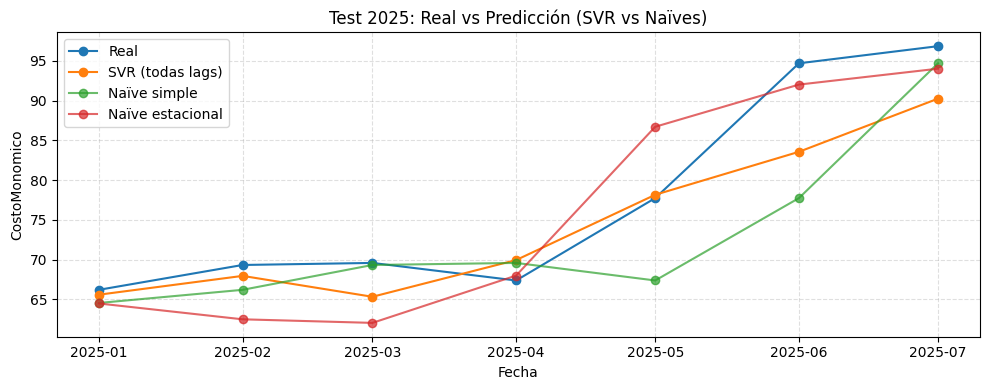

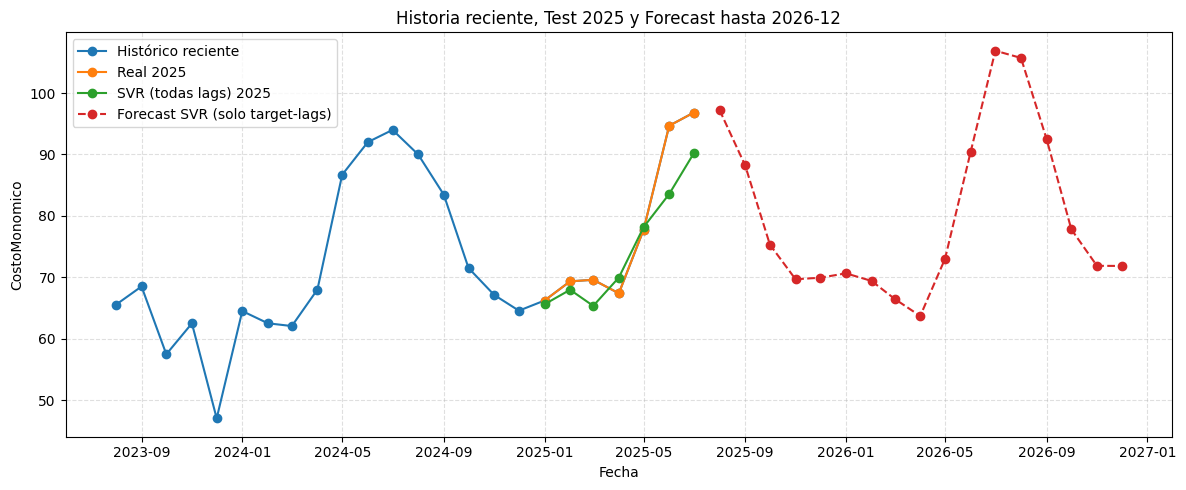

In [ ]:
# ============================
# 0) Features y split temporal (igual que antes)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.tseries.offsets import MonthBegin

# Estacionalidad
df_lagged['mes'] = df_lagged['Fecha'].dt.month
df_lagged['mes_sin'] = np.sin(2*np.pi*df_lagged['mes']/12)
df_lagged['mes_cos'] = np.cos(2*np.pi*df_lagged['mes']/12)

# Split por año
train_mask = df_lagged['Fecha'].dt.year < 2025
test_mask  = df_lagged['Fecha'].dt.year == 2025

target_col = 'CostoMonomico'
lag_cols = [c for c in df_lagged.columns if '_lag' in c]
cal_cols = ['mes_sin', 'mes_cos']
feature_cols = lag_cols + cal_cols   # TODAS las lags (incluye exógenas) + estacionalidad

X_train = df_lagged.loc[train_mask, feature_cols].copy()
y_train = df_lagged.loc[train_mask, target_col].copy()
X_test  = df_lagged.loc[test_mask,  feature_cols].copy()
y_test  = df_lagged.loc[test_mask,  target_col].copy()

print("Train:", X_train.shape, "Test:", X_test.shape)

# =================================================
# 1) Modelo base SVR (todas las lags) en Pipeline
#    (si tenés mejores params, ponelos en best_params_svr)
# =================================================
# Usa los mejores params encontrados
best_params_svr = {'C': 300, 'epsilon': 0.2, 'gamma': 0.001}

svr_base = SVR(
    kernel='rbf',
    C=best_params_svr['C'],
    epsilon=best_params_svr['epsilon'],
    gamma=best_params_svr['gamma']
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', svr_base)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métricas
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = (np.abs((y_test - y_pred) / y_test).mean() * 100)
mae_naive_train = np.mean(np.abs(y_train.values[1:] - y_train.values[:-1]))
mase = mae / mae_naive_train
r2   = r2_score(y_test, y_pred)

print(f"SVR (todas lags) → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | MASE: {mase:.3f} | R²: {r2:.3f}")

# Benchmarks
naive_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag1']
mae_n  = mean_absolute_error(y_test, naive_pred)
rmse_n = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naïve simple (lag1) → MAE: {mae_n:.3f} | RMSE: {rmse_n:.3f}")

naive_seasonal_pred = df_lagged.loc[test_mask, 'CostoMonomico_lag12']
mae_ns  = mean_absolute_error(y_test, naive_seasonal_pred)
rmse_ns = np.sqrt(mean_squared_error(y_test, naive_seasonal_pred))
print(f"Naïve estacional (lag12) → MAE: {mae_ns:.3f} | RMSE: {rmse_ns:.3f}")

# Gráfico comparativo (test 2025)
fechas_test = df_lagged.loc[test_mask, 'Fecha']
plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_test.values, marker='o', label='Real')
plt.plot(fechas_test, y_pred, marker='o', label='SVR (todas lags)')
plt.plot(fechas_test, naive_pred.values, marker='o', alpha=0.7, label='Naïve simple')
plt.plot(fechas_test, naive_seasonal_pred.values, marker='o', alpha=0.7, label='Naïve estacional')
plt.title('Test 2025: Real vs Predicción (SVR vs Naïves)')
plt.xlabel('Fecha'); plt.ylabel(target_col); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout(); plt.show()

# ===========================================================
# 2) Modelo de PROYECCIÓN (solo CostoMonomico_LAGs + mes_sin/cos)
#    -> apto para forecast multi-step
# ===========================================================

# Usaremos exactamente estos lags de la target
desired_lags = [1, 2, 10, 11, 12]

# Construimos los nombres y filtramos por los que REALMENTE existen en df_lagged
mono_lags = [f"CostoMonomico_lag{k}" for k in desired_lags if f"CostoMonomico_lag{k}" in df_lagged.columns]
missing = [f"CostoMonomico_lag{k}" for k in desired_lags if f"CostoMonomico_lag{k}" not in df_lagged.columns]
if missing:
    print("Advertencia: faltan columnas de lag en df_lagged:", missing)

# Estacionalidad (si existe)
seasonals = [c for c in ['mes_sin', 'mes_cos'] if c in df_lagged.columns]
forecast_features = mono_lags + seasonals

Xtr_f = df_lagged.loc[train_mask, forecast_features].copy()
ytr_f = y_train.copy()

forecast_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=30, epsilon=0.05, gamma='scale'))  # cambia por tus mejores params si ya los tenés
])
forecast_model.fit(Xtr_f, ytr_f)

# ===================================================
# 3) Forecast recursivo mensual hasta una fecha dada
# ===================================================
from pandas.tseries.offsets import MonthBegin

def recursive_forecast_to(df_lagged_in, model_fore, feature_names, target_col, end_date='2026-12-01'):
    """
    Forecast 1-step-ahead recursivo usando SOLO las features en 'feature_names'.
    Debe contener algunos de: CostoMonomico_lag{1,2,10,11,12} y mes_sin/mes_cos si existen.
    """
    # Validación de features
    missing_in_df = [c for c in feature_names if c not in df_lagged_in.columns]
    if missing_in_df:
        raise KeyError(f"Estas features no están en df_lagged_in: {missing_in_df}")

    dfw = df_lagged_in[['Fecha', target_col] + feature_names].copy().sort_values('Fecha').reset_index(drop=True)
    last_date = dfw['Fecha'].max()
    fut_dates = pd.date_range(pd.to_datetime(last_date) + MonthBegin(1), end=pd.to_datetime(end_date), freq='MS')

    # De los feature_names, detectamos qué lags de la target vamos a usar
    used_lags = sorted([
        int(c.replace('CostoMonomico_lag',''))
        for c in feature_names if c.startswith('CostoMonomico_lag')
    ])
    max_k = max(used_lags) if used_lags else 0

    hist = dfw.copy()
    out = []

    for d in fut_dates:
        mes = d.month
        feat_row = {}

        y_hist = hist[target_col].values
        if max_k > 0 and len(y_hist) < max_k:
            raise ValueError(f"Se requieren al menos {max_k} observaciones históricas para usar lag{max_k}.")

        # Cargamos dinámicamente los lags que estén en feature_names
        for k in used_lags:
            feat_row[f"CostoMonomico_lag{k}"] = y_hist[-k]

        # Estacionalidad si corresponde
        if 'mes_sin' in feature_names: feat_row['mes_sin'] = np.sin(2*np.pi*mes/12)
        if 'mes_cos' in feature_names: feat_row['mes_cos'] = np.cos(2*np.pi*mes/12)

        row = pd.DataFrame([{**{'Fecha': d}, **feat_row}])
        X_row = row[feature_names]
        y_hat = model_fore.predict(X_row)[0]

        out.append({'Fecha': d, target_col: y_hat})

        # Extendemos histórico SOLO con la target (para actualizar lags en el próximo paso)
        hist = pd.concat([hist, pd.DataFrame({'Fecha': [d], target_col: [y_hat]})], ignore_index=True)

    return pd.DataFrame(out)

# ==========================
# 4) Pronóstico hasta 2026-12 (usando los lags 1,2,10,11,12)
# ==========================
future_fc = recursive_forecast_to(
    df_lagged_in=df_lagged,
    model_fore=forecast_model,
    feature_names=forecast_features,  # ahora solo incluye lags existentes de {1,2,10,11,12} + estacionalidad
    target_col=target_col,
    end_date='2026-12-01'
)

# ==========================
# 5) Gráfico historia + test + forecast
# ==========================
hist_plot_months = 24  # últimos 24 meses
hist_data = df_lagged[['Fecha', target_col]].copy()
hist_tail = hist_data.tail(hist_plot_months)

plt.figure(figsize=(12,5))
plt.plot(hist_tail['Fecha'], hist_tail[target_col], marker='o', label='Histórico reciente')
plt.plot(fechas_test, y_test.values, marker='o', label='Real 2025')
plt.plot(fechas_test, y_pred, marker='o', label='SVR (todas lags) 2025')
plt.plot(future_fc['Fecha'], future_fc[target_col], marker='o', label='Forecast SVR (solo target-lags)', linestyle='--')
plt.title('Historia reciente, Test 2025 y Forecast hasta 2026-12')
plt.xlabel('Fecha'); plt.ylabel(target_col); plt.legend()
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout(); plt.show()


In [ ]:
# Renombrar la columna objetivo para que quede claro que es predicción
df_forecast_vals = future_fc.rename(columns={target_col: 'SVR_forecast'}).copy()

print("Predicciones de forecast (primeras filas):")
print(df_forecast_vals.head(12))
print("…")
print(df_forecast_vals.tail(12))

# (opcional) Guardar a CSV
df_forecast_vals.to_csv('predicciones_forecast_SVR.csv', index=False)

Predicciones de forecast (primeras filas):
        Fecha  SVR_forecast
0  2025-08-01     97.241142
1  2025-09-01     88.209732
2  2025-10-01     75.300876
3  2025-11-01     69.674303
4  2025-12-01     69.923483
5  2026-01-01     70.637607
6  2026-02-01     69.403146
7  2026-03-01     66.477170
8  2026-04-01     63.683245
9  2026-05-01     72.996282
10 2026-06-01     90.398028
11 2026-07-01    106.907452
…
        Fecha  SVR_forecast
5  2026-01-01     70.637607
6  2026-02-01     69.403146
7  2026-03-01     66.477170
8  2026-04-01     63.683245
9  2026-05-01     72.996282
10 2026-06-01     90.398028
11 2026-07-01    106.907452
12 2026-08-01    105.730215
13 2026-09-01     92.528360
14 2026-10-01     77.795302
15 2026-11-01     71.864099
16 2026-12-01     71.841032
